# MUSIC (MUltiple SIgnal Classification) Notebook

The MUSIC (MUltiple SIgnal Classification) algorithm is a rather generic and well-know algorithm in signal process used for the detection of multiple waves within an array of sensors [Schmidt, 1986].  MUSIC was originally used in SuperDARN by Samson et al. [1990] and Bristow et al. [1994] for the estimation of the characteristics of Medium Scale Traveling Ionospheric Disturbances (MSTIDs) detected by SuperDARN Radars.  These papers have inspired this implementation of the MUSIC algorithm.

While this code has been written with SuperDARN detected MSTIDs in mind, it may be useful for working with other wave-like perturbations moving across the field of view of some geophysical instrument.

This notebook demonstrates the use of the DaViTPy MUSIC module for MSTID parameter estimation.

The DaViTPy MUSIC module is used by creating a musicArray object, which includes built-in methods for keeping track of all steps in the processing algorithm.  As the data is processed, all preceeding variants of the data are saved within the object and a history is created.  This makes it very easy to see what has been done with the data at any step along the way.

*Written by N.A. Frissell, 4 November 2013.*

*Updated by: Francis Tholley Jun, 2022*

**References**

Bristow, W. A., R. A. Greenwald, and J. C. Samson (1994), Identification of high-latitude acoustic gravity wave sources using the Goose Bay HF Radar, J. Geophys. Res., 99(A1), 319–331, doi:10.1029/93JA01470.

Samson, J. C., R. A. Greenwald, J. M. Ruohoniemi, A. Frey, and K. B. Baker (1990), Goose Bay radar observations of Earth-reflected, atmospheric gravity waves in the high-latitude ionosphere, J. Geophys. Res., 95(A6), 7693–7709, doi:10.1029/JA095iA06p07693.

Schmidt, R.O., "Multiple emitter location and signal parameter estimation," Antennas and Propagation, IEEE Transactions on, vol.34, no.3, pp.276,280, Mar 1986, doi:10.1109/TAP.1986.1143830.

In [1]:
#Import the modules we need.
%matplotlib inline
import datetime

from matplotlib import pyplot as plt 
import numpy as np
from pyDARNmusic import musicRTP,musicFan,timeSeriesMultiPlot,plotRelativeRanges,spectrumMultiPlot,plotFullSpectrum,plotDlm, plotKarr,plotKarrDetected
from pyDARNmusic import load_fitacf
from pyDARNmusic import music
from pyDARNmusic import (getDataSet 
                              ,stringify_signal,stringify_signal_list     
                               ,beamInterpolation         
                               ,defineLimits              
                               ,checkDataQuality          
                               ,applyLimits               
                               ,determineRelativePosition 
                               ,timeInterpolation         
                               ,filterTimes               
                               ,detrend                   
                               ,nan_to_num                
                               ,windowData                
                               ,calculateFFT              
                               ,calculateDlm              
                               ,calculateKarr             
                               ,simulator                 
                               ,scale_karr                
                               ,detectSignals             
                               ,add_signal                
                               ,del_signal)
# from music import defineLimits, filterTimes,beamInterpolation,timeInterpolation,determineRelativePosition


import pydarn
import pydarnio


IMPORTANT: Please make sure to cite pyDARN in publications that use plots created by pyDARN using DOI: https://zenodo.org/record/3727269. Citing information for SuperDARN data is found at https://pydarn.readthedocs.io/en/master/user/citing/


# MUSIC Processing Example

## Loading Data and Basic Plotting

In [2]:
radar   = 'bpk'
sDate   = datetime.datetime(2017,1,15,1)
eDate   = datetime.datetime(2017,1,15,23)
fit_sfx = "fitacf"
data_dir = f'/home/fran/code/SuperdarnW3usr/ForGitRepo/'
fitacf  = load_fitacf(radar,sDate,eDate,data_dir=data_dir)

Loading fitacf Files:   0%|                              | 0/12 [00:00<?, ?it/s]

/home/fran/code/SuperdarnW3usr/ForGitRepo/2017/fitacf/bpk/20170115.0001.00.bpk.fitacf.bz2


Loading fitacf Files:   8%|█▊                    | 1/12 [00:02<00:28,  2.60s/it]

/home/fran/code/SuperdarnW3usr/ForGitRepo/2017/fitacf/bpk/20170115.0201.00.bpk.fitacf.bz2


Loading fitacf Files:  17%|███▋                  | 2/12 [00:05<00:27,  2.71s/it]

/home/fran/code/SuperdarnW3usr/ForGitRepo/2017/fitacf/bpk/20170115.0401.00.bpk.fitacf.bz2


Loading fitacf Files:  25%|█████▌                | 3/12 [00:08<00:24,  2.74s/it]

/home/fran/code/SuperdarnW3usr/ForGitRepo/2017/fitacf/bpk/20170115.0601.00.bpk.fitacf.bz2


Loading fitacf Files:  33%|███████▎              | 4/12 [00:11<00:22,  2.82s/it]

/home/fran/code/SuperdarnW3usr/ForGitRepo/2017/fitacf/bpk/20170115.0801.00.bpk.fitacf.bz2


Loading fitacf Files:  42%|█████████▏            | 5/12 [00:14<00:20,  2.94s/it]

/home/fran/code/SuperdarnW3usr/ForGitRepo/2017/fitacf/bpk/20170115.1001.00.bpk.fitacf.bz2


Loading fitacf Files:  50%|███████████           | 6/12 [00:17<00:17,  2.92s/it]

/home/fran/code/SuperdarnW3usr/ForGitRepo/2017/fitacf/bpk/20170115.1201.00.bpk.fitacf.bz2


Loading fitacf Files:  58%|████████████▊         | 7/12 [00:19<00:14,  2.90s/it]

/home/fran/code/SuperdarnW3usr/ForGitRepo/2017/fitacf/bpk/20170115.1401.00.bpk.fitacf.bz2


Loading fitacf Files:  67%|██████████████▋       | 8/12 [00:23<00:11,  2.95s/it]

/home/fran/code/SuperdarnW3usr/ForGitRepo/2017/fitacf/bpk/20170115.1601.00.bpk.fitacf.bz2


Loading fitacf Files:  75%|████████████████▌     | 9/12 [00:26<00:08,  2.96s/it]

/home/fran/code/SuperdarnW3usr/ForGitRepo/2017/fitacf/bpk/20170115.1801.00.bpk.fitacf.bz2


Loading fitacf Files:  83%|█████████████████▌   | 10/12 [00:29<00:05,  2.96s/it]

/home/fran/code/SuperdarnW3usr/ForGitRepo/2017/fitacf/bpk/20170115.2001.00.bpk.fitacf.bz2


Loading fitacf Files:  92%|███████████████████▎ | 11/12 [00:32<00:02,  2.99s/it]

/home/fran/code/SuperdarnW3usr/ForGitRepo/2017/fitacf/bpk/20170115.2201.00.bpk.fitacf.bz2


Loading fitacf Files: 100%|█████████████████████| 12/12 [00:35<00:00,  2.95s/it]


In [3]:
# print(fitacf[0]["stid"])

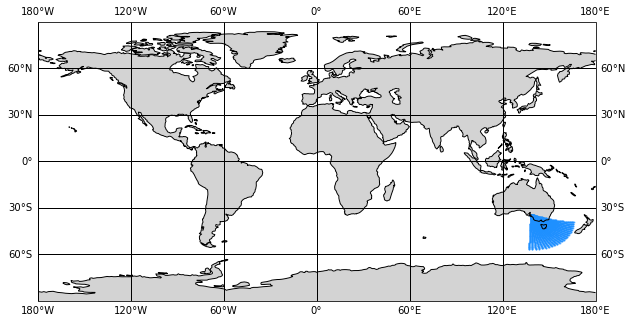

In [4]:
# Now create the data object.

# By creating this object, data is taken from the SuperDARN database and rearranged into a numpy.array with
# the shape (Nr Times, Nr Beams, Nr Gates).  Missing data is stored as np.nan.

# By default, this command only loads in data where the ground scatter flag is True.

# The fovModel='GS' indicates to calculate the field-of-view coordinates in using the ground-scatter mapping
# formula.  This is standard when looking at MSTIDs using ground scatter.  See Bristow et al. [1994] for details.
# dataObj_IS     = musicArray(myPtr,fovModel='IS')
dataObj = music.musicArray(fitacf,sTime=sDate,eTime=eDate,fovModel='GS')

In [5]:
# We can list all of the data sets stored in this object.  Right now there is only one data set, but
# as we go along, each step of processing will create a new data set.

# Each data set is simply stored as an attribute of the dataObj, but the names of all of the data sets can be
# accessed through the get_data_sets() method.
dataObj.get_data_sets()

['DS000_originalFit']

In [6]:
# Information about the data set is saved in it's metadata dictionary.  Some of the information in the metadata
# dictionary is used to control certain plotting and processing variables in this module.

dataObj.DS000_originalFit.printMetadata()

channel: all
code:  bpk
coords: geo
cp: None
dType: dmap
dataSetName: DS000_originalFit
eTime: 2017-01-15 23:00:00
elevation: None
fType: fitacf
gscat: 1
model: GS
name:  Buckland Park
param: p_l
sTime: 2017-01-15 01:00:00
serial: 0
stid: 24


In [7]:
# The music module also keeps track of each step of processing in using the data set's history attribute.

dataObj.DS000_originalFit.printHistory()

2022-09-13 14:29:08.577986 [DS000_originalFit] Original Fit Data


In [8]:
# The 'active' attribute of dataObj is a reference to the most recently used data set of dataObj.  It is also
# the default data set used by all DaViTPy MUSIC processing and plotting routines.  You can see this command
# produces the same result as the cell above.

dataObj.active.printHistory()

2022-09-13 14:29:08.577986 [DS000_originalFit] Original Fit Data


/home/fran/code/newMusic/MUSIC/pyDARNmusic/plotting/rtp.py: 342: UserWarning: FixedFormatter should only be used together with FixedLocator


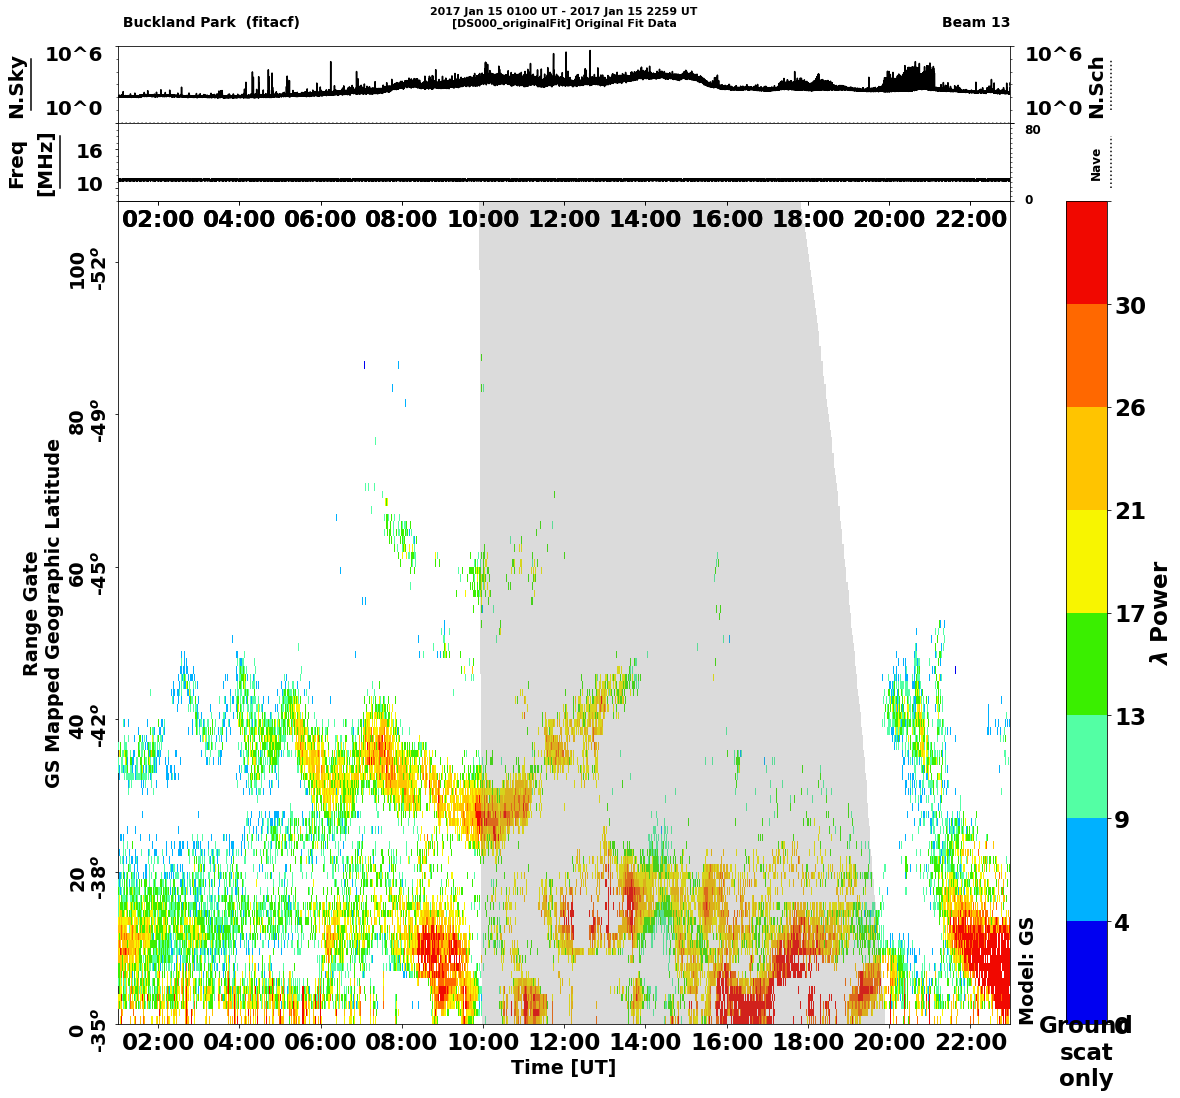

In [9]:
# We can create an RTP plot and a fan plot from the data we loaded.
# You can see that both range gate and geographic latitude are given on the y-axis, and the solar terminator
# is also shaded in.  The terminator does not go below approximately range gate 10.  This is because the ground
# scatter mapping formula is not defined for close-in range gates.

fig = musicRTP(dataObj,beam=13)

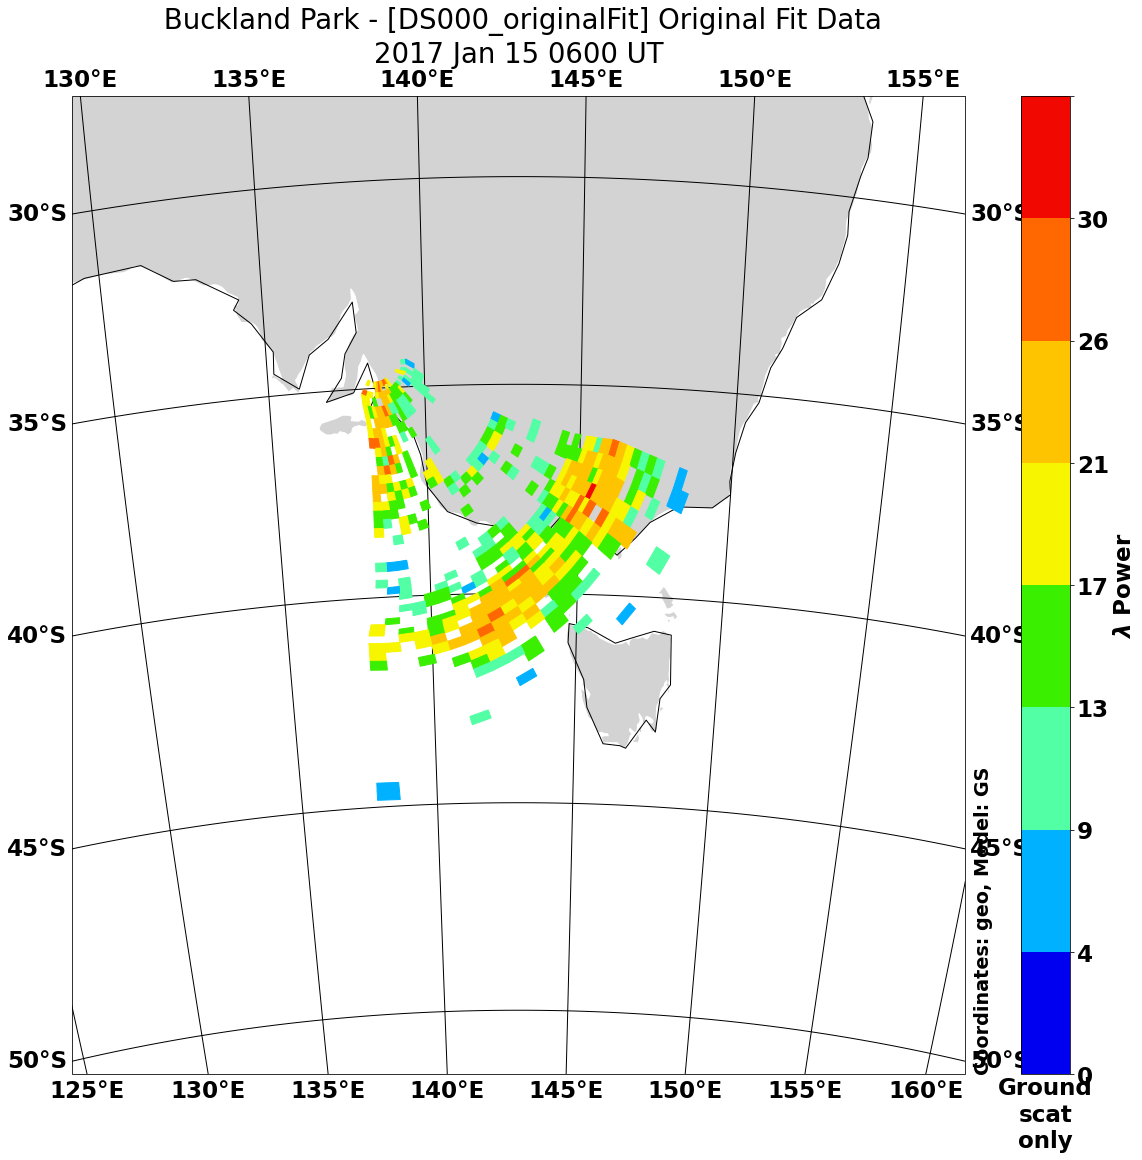

In [10]:
# We can also make a fan plot.

plotTime = datetime.datetime(2017,1,15,6,0)
fig = musicFan(dataObj,time=plotTime)
# import ipdb;ipdb.set_trace()


## Data Selection

/home/fran/code/newMusic/MUSIC/pyDARNmusic/plotting/rtp.py: 342: UserWarning: FixedFormatter should only be used together with FixedLocator


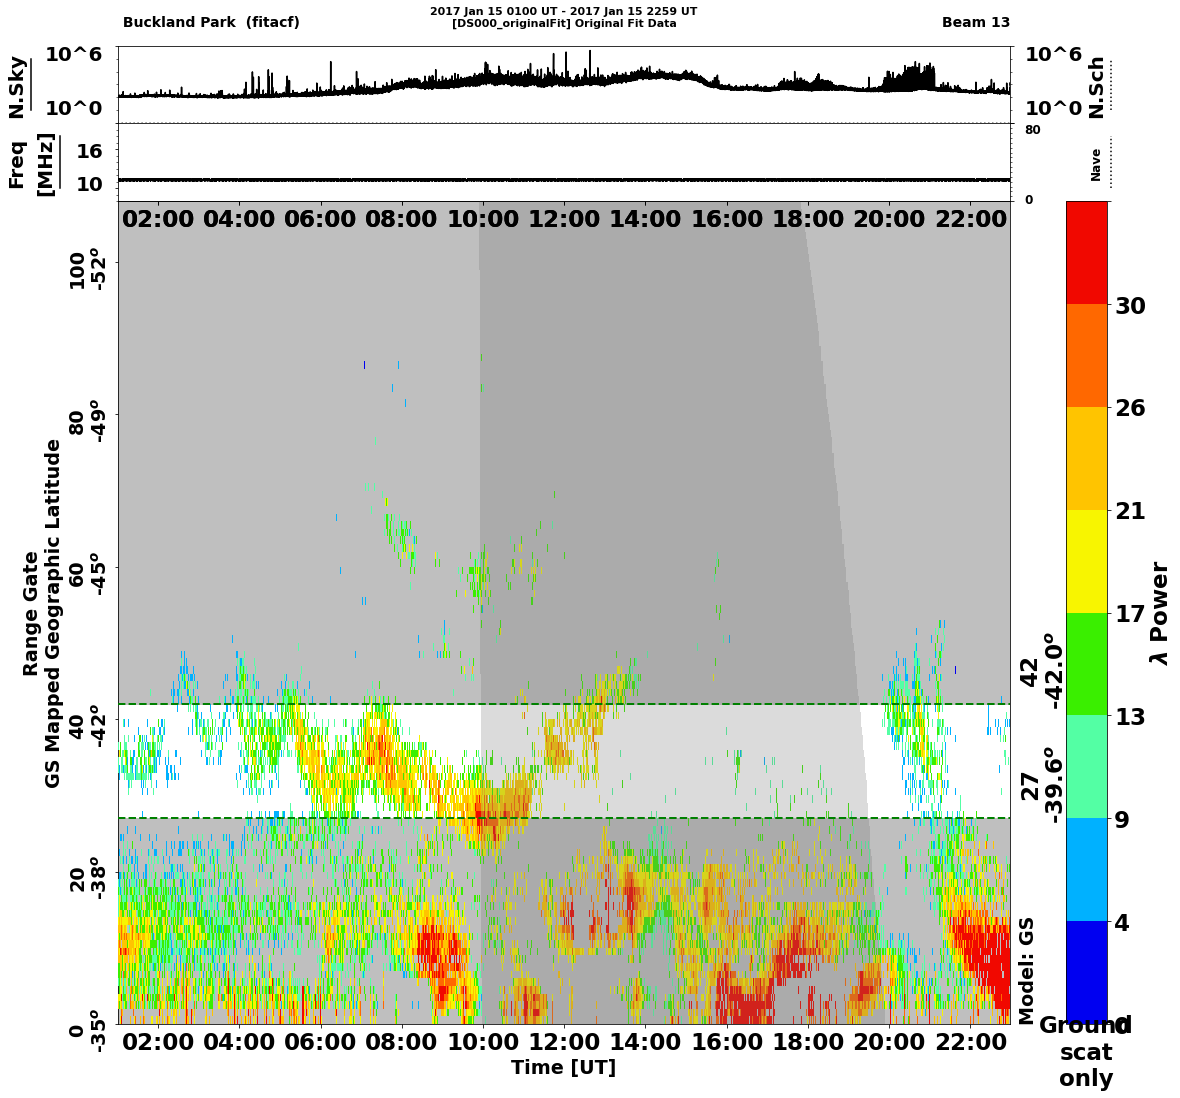

In [11]:
# We want to focus on just the data that contains the MSTID we are looking for, so we can apply some limits.

# proc.music.defineLimits() does not actually modify the data, it just marks the data by putting an an entry
# into the dataObj.active.metadata dictionary.  The limits will be applied later.  Right now, you can see
# what data will be eliminated by making a new RTP plot.

defineLimits(dataObj,gateLimits=[27,42])
fig = musicRTP(dataObj,beam=13)

/home/fran/code/newMusic/MUSIC/pyDARNmusic/plotting/rtp.py: 342: UserWarning: FixedFormatter should only be used together with FixedLocator


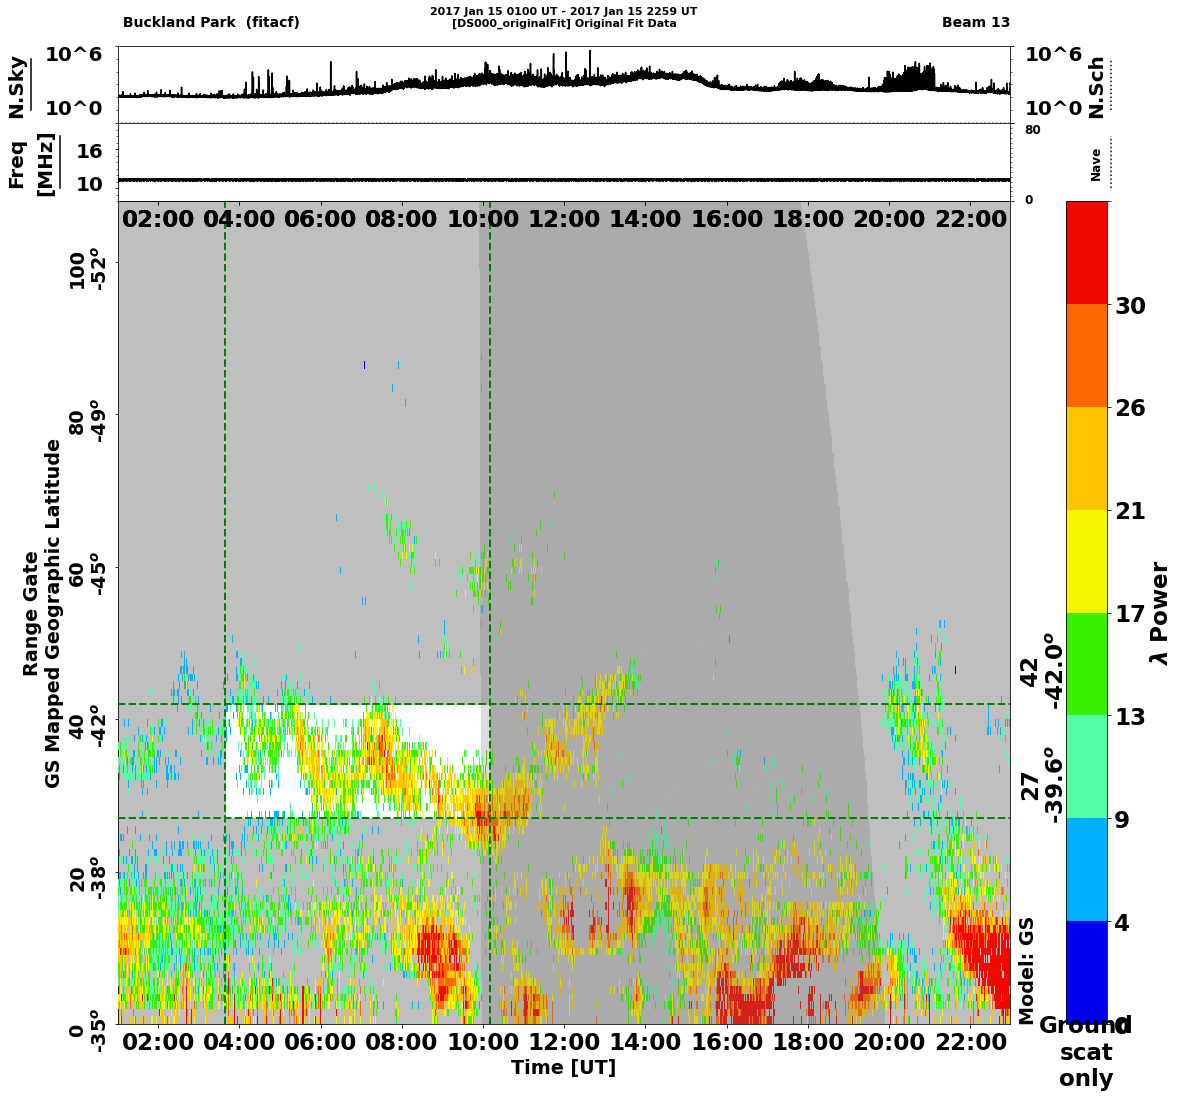

In [12]:
# We also to restrict the amount of time we process.  Before actually running the music algorithm, we
# will be filtering the data using a FIR filter that will eat up data at the beginning and end of the filter.
# We can calculate exactly how much time that will be if we know some of the filter characteristics and
# the time resolution of the data.  This can then be used to give us new start and end times.

# For now, let's say we are going to use a filter with 101 taps and a dataset with 120 s resolution.
numtaps = 101
timeres = 120
# numtaps = 8
# timeres = 7

#Let's also say that we are interested in the MSTID feature between 1400 and 1600 UT.
sTime_of_interest = datetime.datetime(2017,1,15,5,20)
eTime_of_interest = datetime.datetime(2017,1,15,8,30)

#Now calculate the new start and end times...
new_times = filterTimes(sTime_of_interest, eTime_of_interest, timeres, numtaps)
defineLimits(dataObj,timeLimits=new_times)

fig = musicRTP(dataObj,beam=13)
# fig.savefig("/home/fran/Pictures/CEDAR2022/gateandtimelimitRTP.png")

/home/fran/code/newMusic/MUSIC/pyDARNmusic/plotting/rtp.py: 342: UserWarning: FixedFormatter should only be used together with FixedLocator


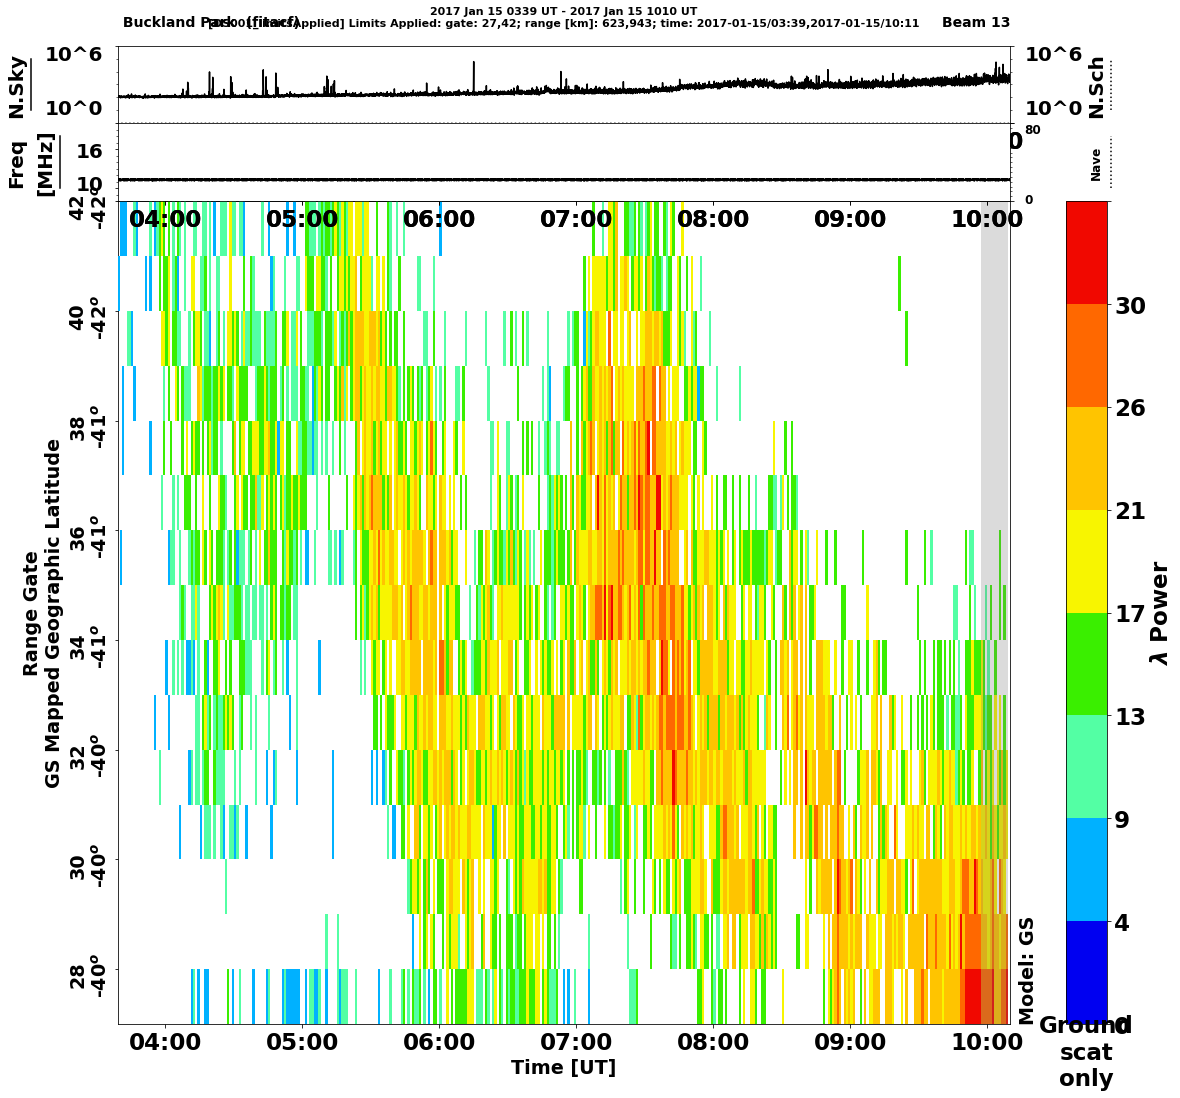

In [13]:
# Now we apply the limits and replot once more.
# Note that many of the processing routines will automatically call applyLimits() before they
# run the processing algorithm.
# prob
dataObj.active.applyLimits()
fig = musicRTP(dataObj,beam=13)

In [14]:
# Note that a new data set was created when we applied the limits.
dataObj.get_data_sets()

['DS000_originalFit', 'DS001_limitsApplied']

In [15]:
# Also note that the history of the new object was updated.
dataObj.active.printHistory()

2022-09-13 14:29:08.577986 [DS000_originalFit] Original Fit Data
2022-09-13 14:29:28.744609 [DS001_limitsApplied] Limits Applied: gate: 27,42; range [km]: 623,943; time: 2017-01-15/03:39,2017-01-15/10:11


## Data Processing

### Interpolation and Cartesian Coordinates

In [16]:
# Before we feed into the MUSIC Algorithm, we don't want our data to have any gaps in time or space.
# Let's start by interpolating in space along the beams.
beamInterpolation(dataObj)

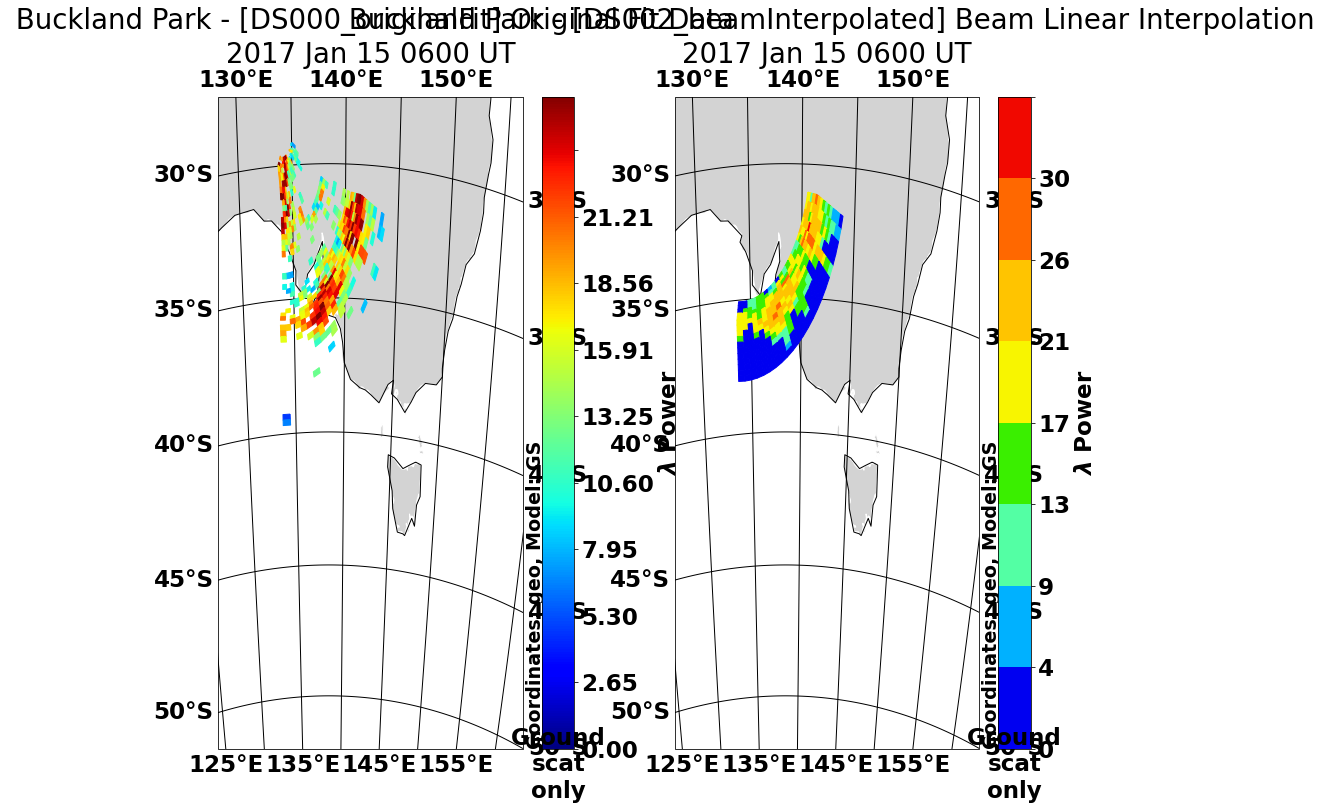

In [17]:
from pydarn import SuperDARNRadars
import cartopy.crs as ccrs
# get the radar location for the projection
stid = fitacf[0]["stid"]
radar_lat = SuperDARNRadars.radars[stid].hardware_info.geographic.lat
radar_lon = SuperDARNRadars.radars[stid].hardware_info.geographic.lon
# set the radar location as the center
proj = ccrs.Orthographic(radar_lon,radar_lat)

fig = plt.figure(figsize=(15,12))
ax  = fig.add_subplot(121, projection=proj, aspect='auto')
musicFan(dataObj,plotZeros=True,axis=ax, dataSet='originalFit',time=plotTime,autoScale=True)

ax  = fig.add_subplot(122, projection=proj, aspect='auto')
musicFan(dataObj,plotZeros=True,axis=ax,time=plotTime)

In [18]:
# musicFan(dataObj,plotZeros=True,time=plotTime)

In [19]:
%debug
# We also want to interpolate in time.  timeres=120 [seconds] was set in an earlier cell.
timeInterpolation(dataObj,timeRes=timeres)

ERROR:root:No traceback has been produced, nothing to debug.


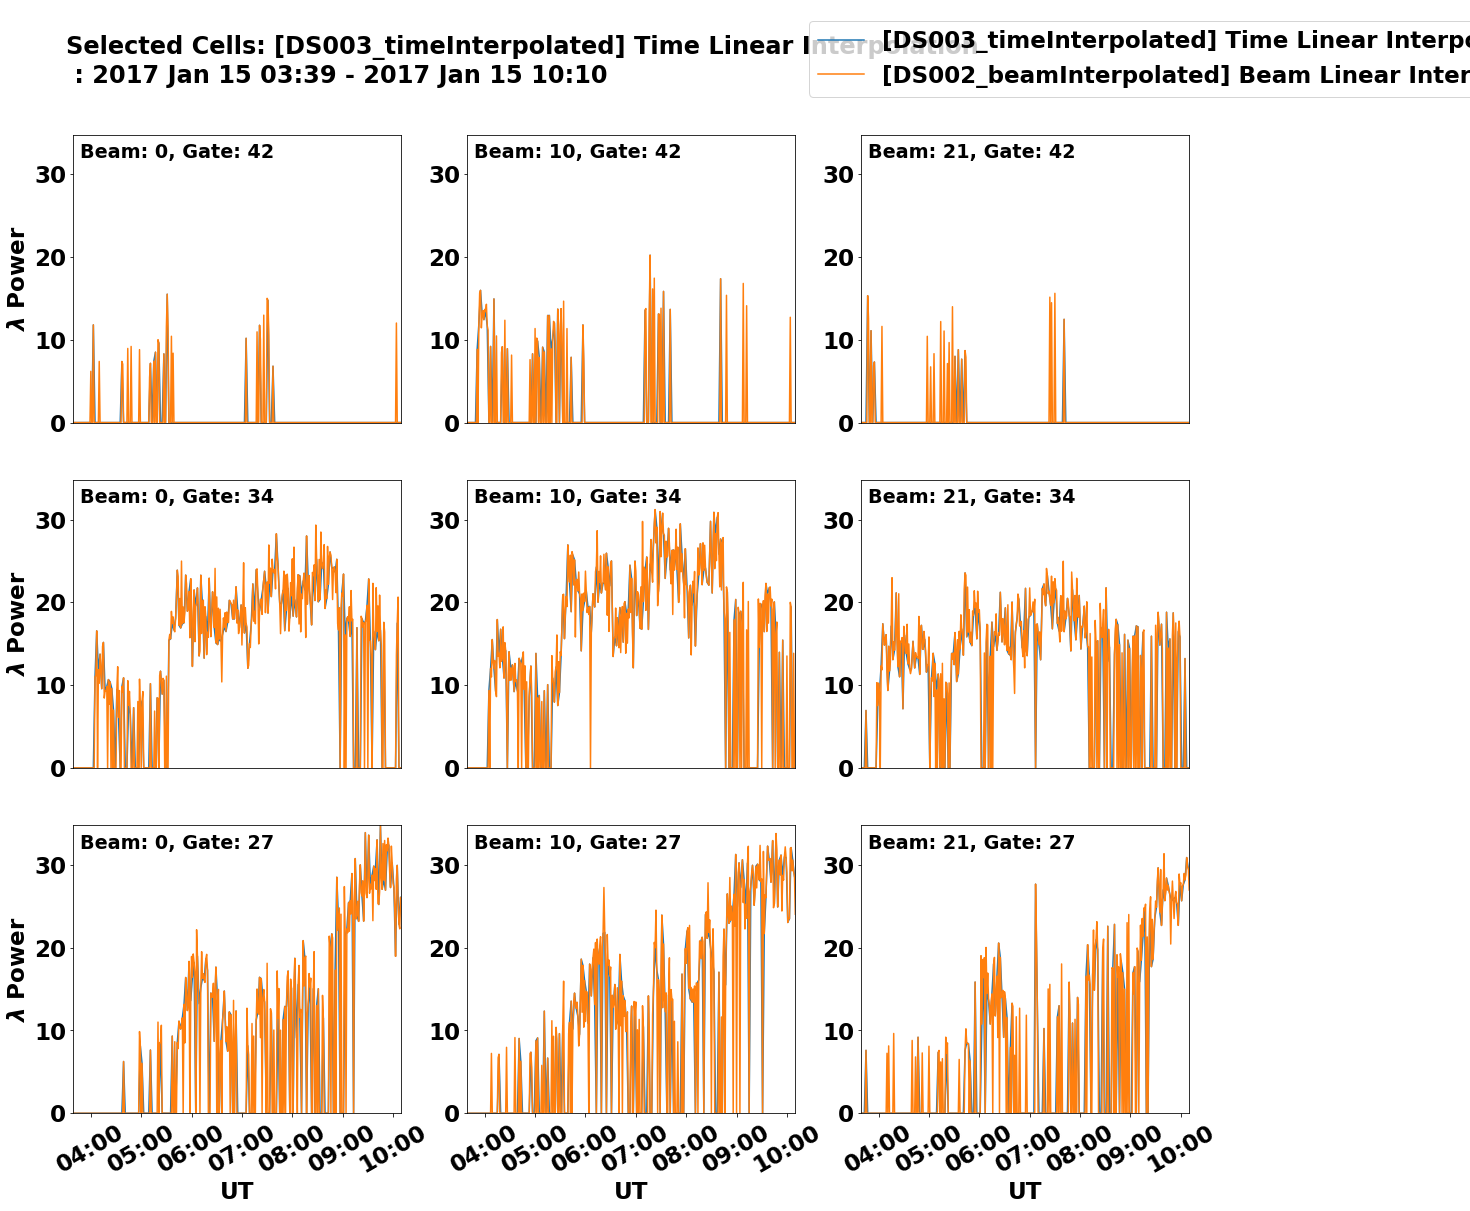

In [20]:
timeSeriesMultiPlot(dataObj,dataSet='timeInterpolated',dataSet2='beamInterpolated')

In [21]:
# We also want need to calculate a local cartesian grid for each cell we are going to use.
determineRelativePosition(dataObj)

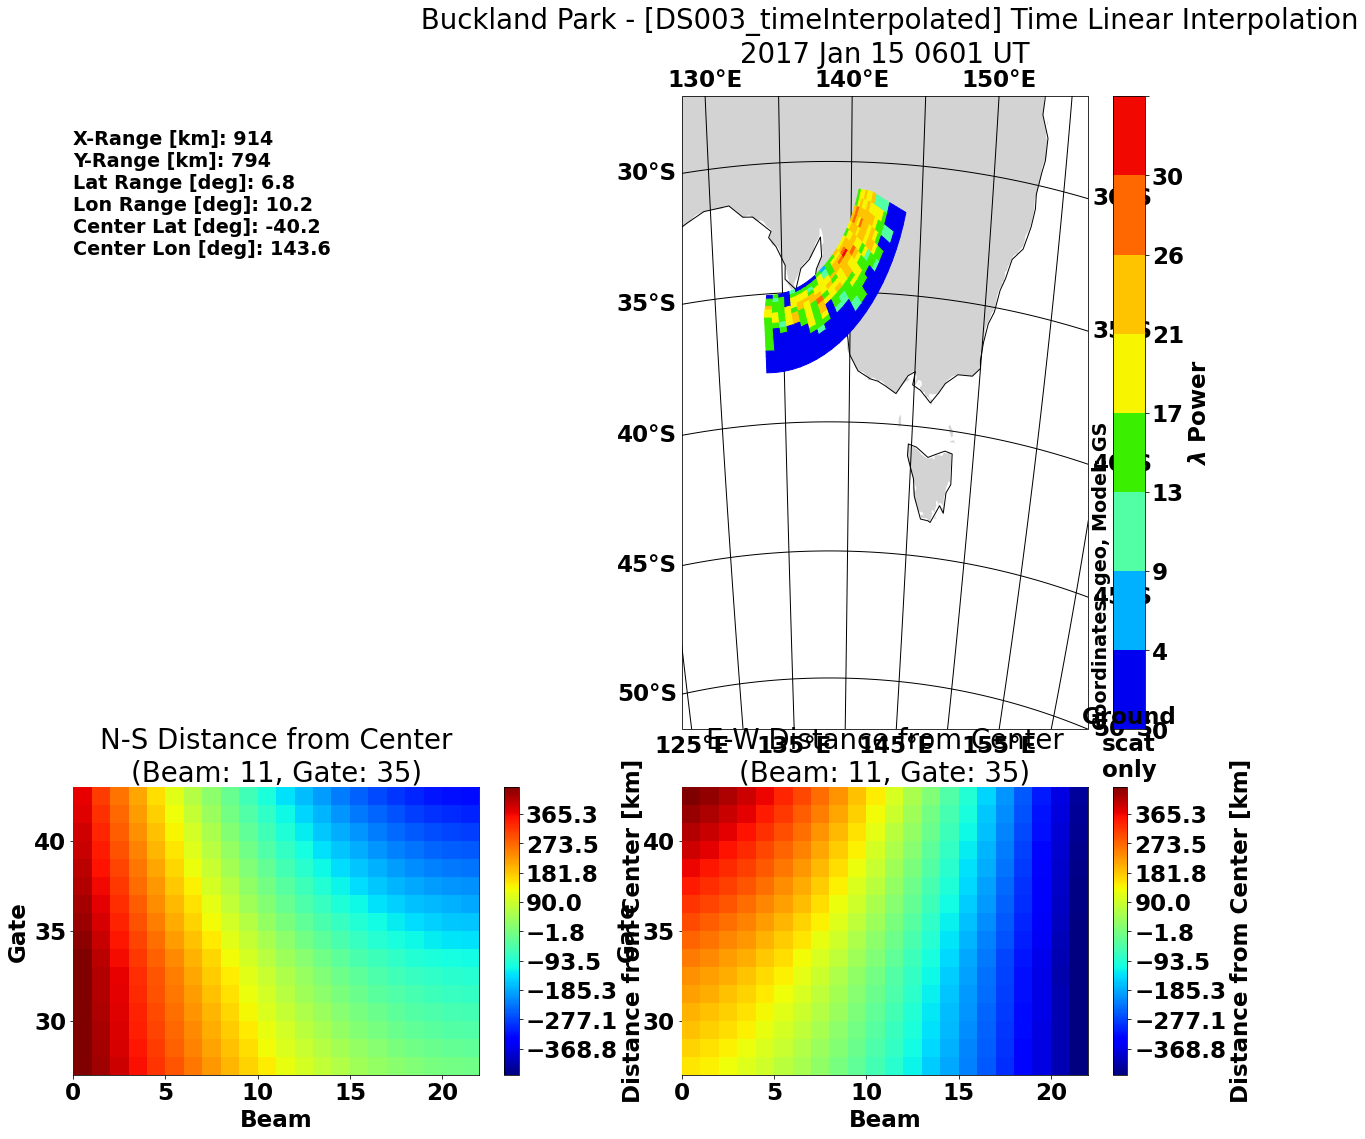

In [22]:
#The black cell marks the center of the array.
fig = plotRelativeRanges(dataObj,time=plotTime)

### Filtering

In [23]:
# Now filter the data.
# numtaps=101 was set in an above cell.  The cutoff_frequencies are in Hz.

filt = music.filter(dataObj, numtaps=numtaps, cutoff_low=0.0003, cutoff_high=0.0012)

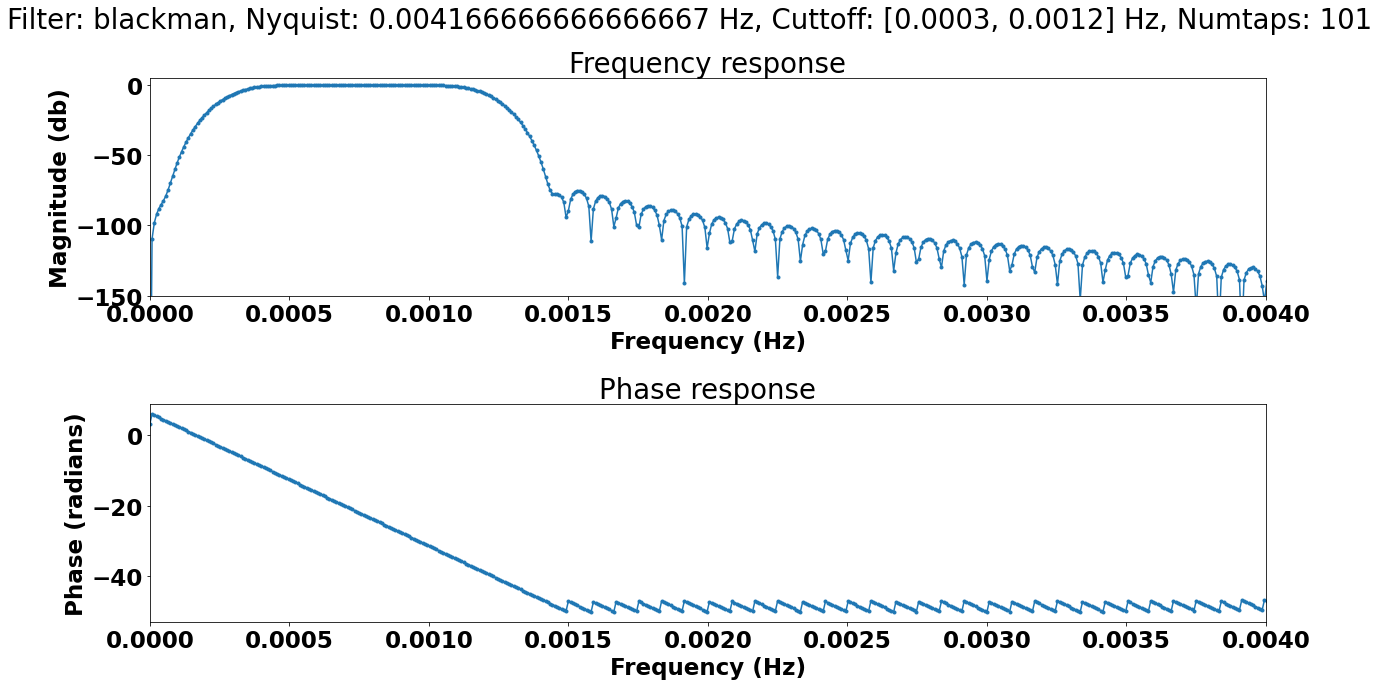

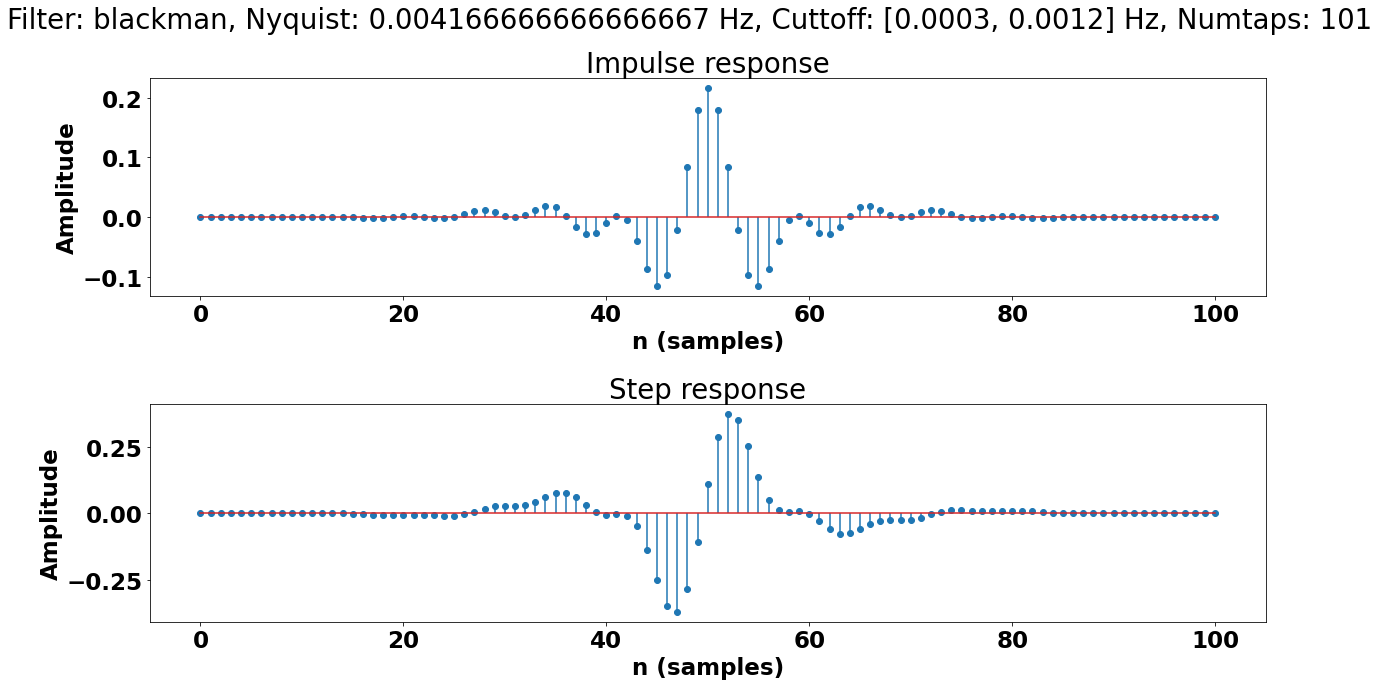

In [24]:
# At this point, the data has been filtered and saved to a new data set in dataObj.
# Before we look at the data, let's look at the transfer function and impulse response of the data.

fig = filt.plotTransferFunction(xmax=0.004)
fig = filt.plotImpulseResponse()

/home/fran/code/newMusic/MUSIC/pyDARNmusic/plotting/rtp.py: 342: UserWarning: FixedFormatter should only be used together with FixedLocator


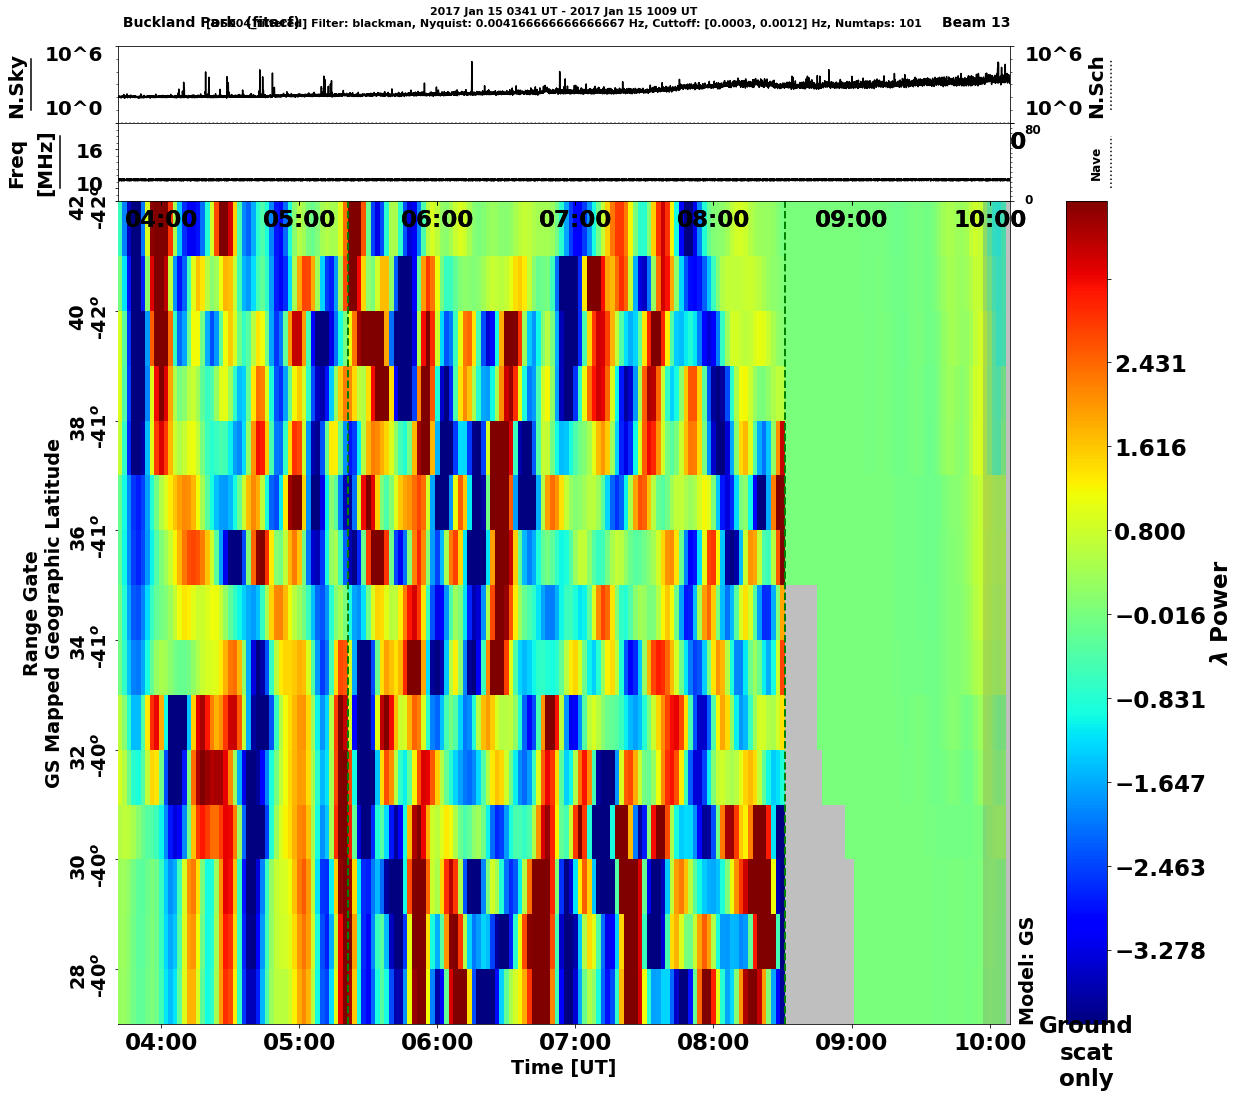

In [25]:
# Let's look at the filtered RTP plot.  We should set autoScale to True since the magnitudes will be much
# lower than the original data.

fig = musicRTP(dataObj,beam=13,autoScale=True)

/home/fran/code/newMusic/MUSIC/pyDARNmusic/plotting/rtp.py: 342: UserWarning: FixedFormatter should only be used together with FixedLocator


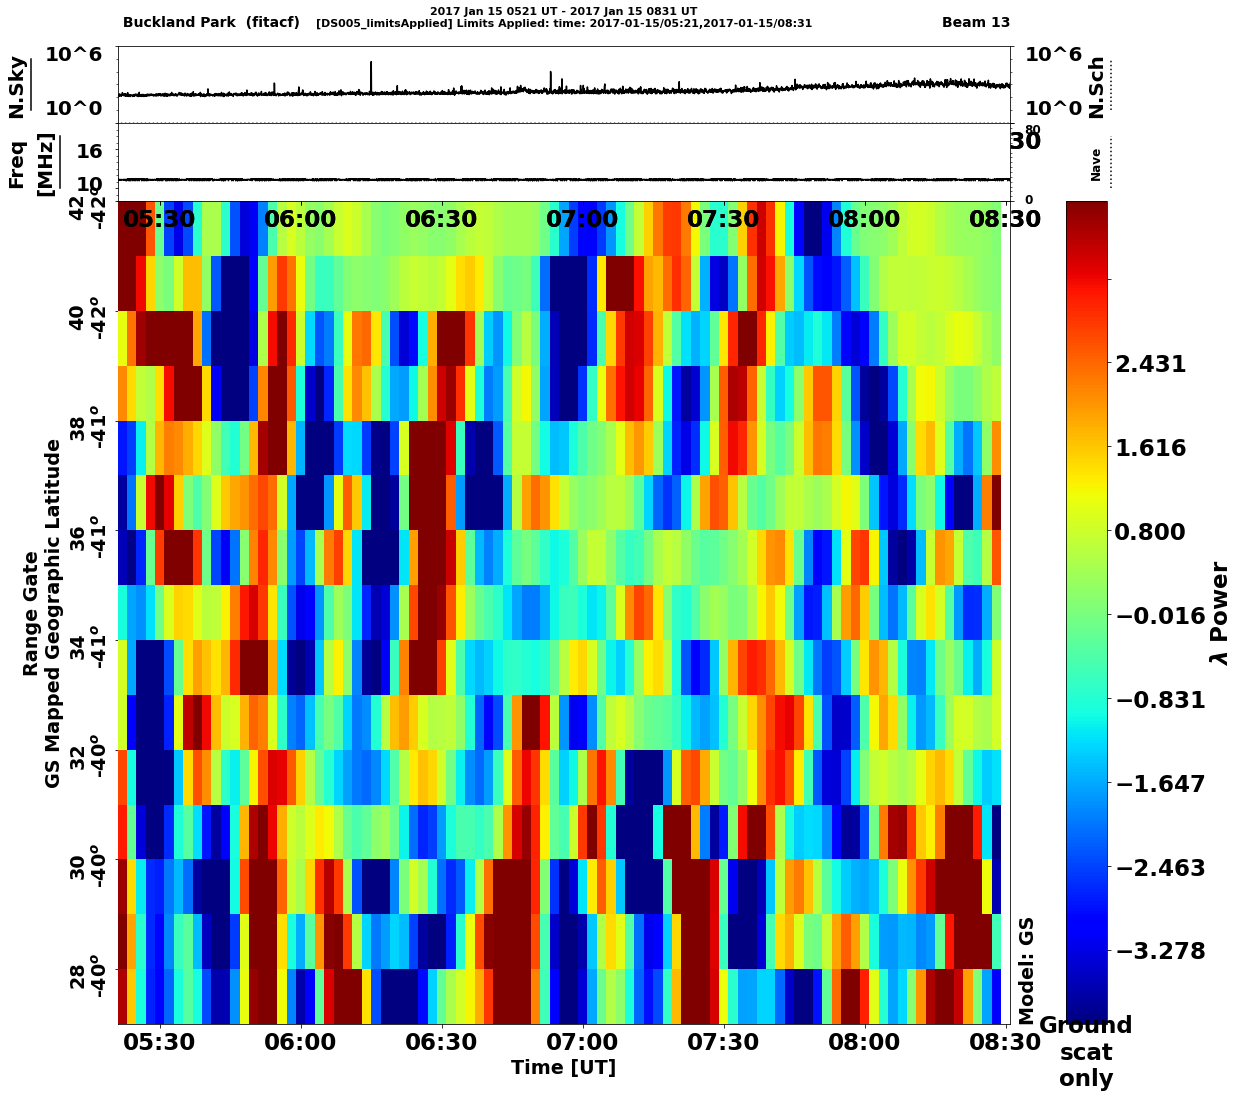

In [26]:
# You can see that the filter already marked off the data that you shouldn't use.
# Just applyLimits() and replot.
dataObj.active.applyLimits()
fig = musicRTP(dataObj,beam=13,autoScale=True)
# fig.savefig("/home/fran/Pictures/CEDAR2022/limitRTPintime.png")

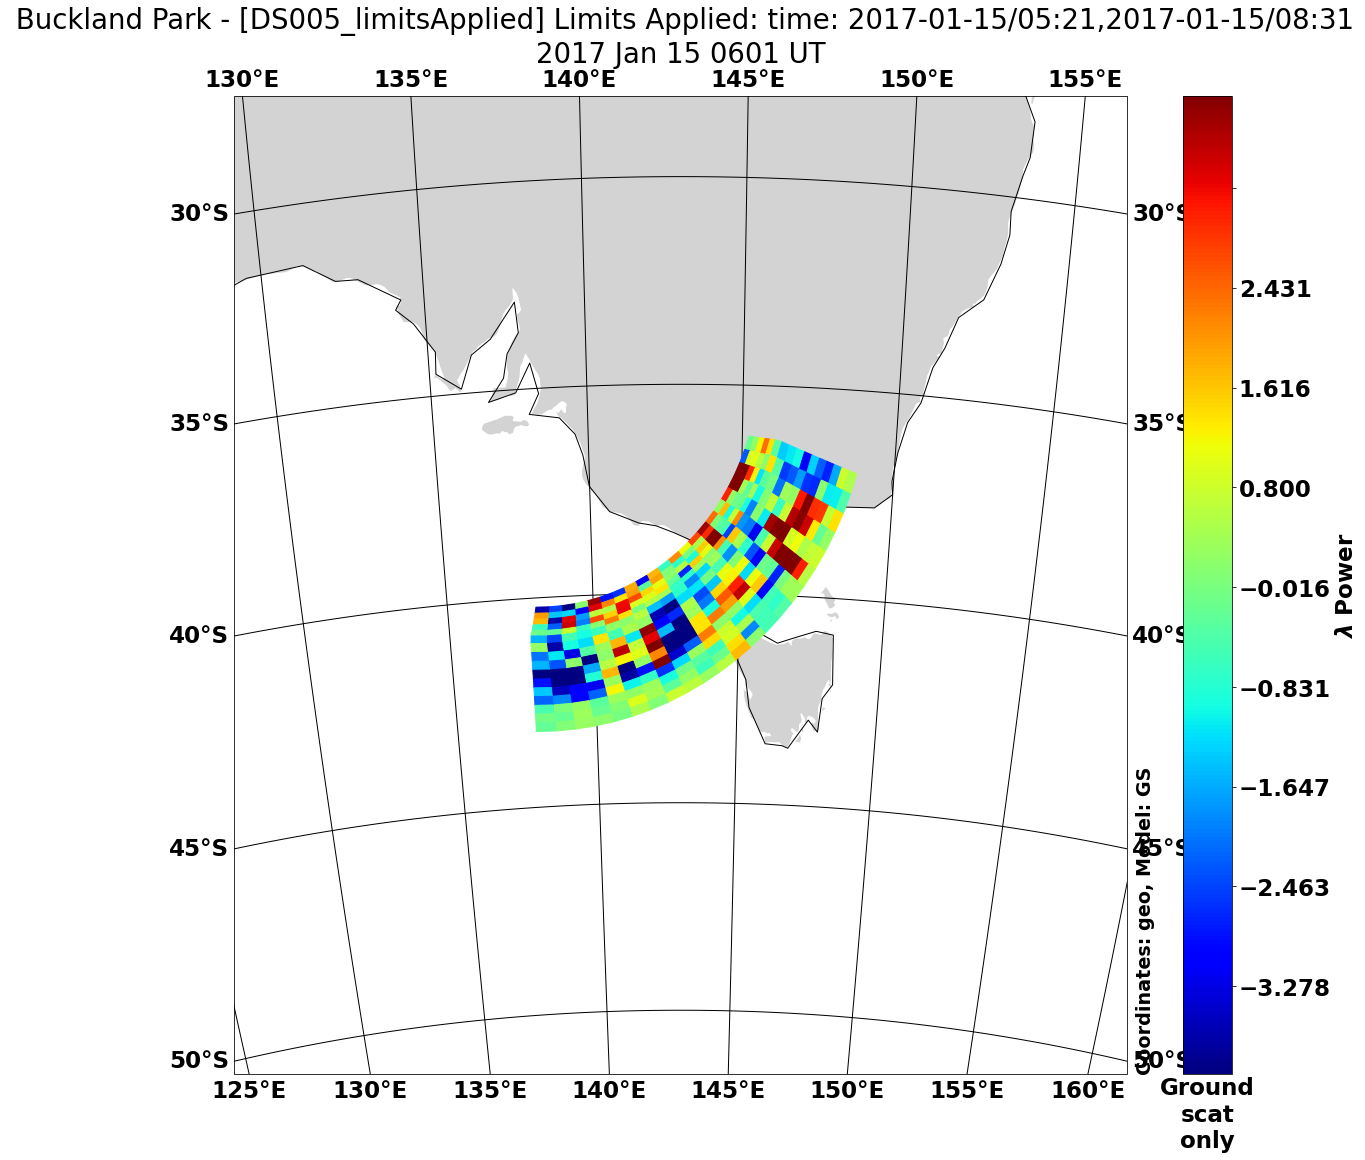

In [27]:
# Look at a fan plot.
fig = musicFan(dataObj,time=plotTime,autoScale=True)

### Spectral Analysis

In [28]:
# We have now run all of the processing needed to feed the data into the spectral analysis and MUSIC.
# Let's print the history just to recap what we have done.
dataObj.active.printHistory()

2022-09-13 14:29:08.577986 [DS000_originalFit] Original Fit Data
2022-09-13 14:29:28.744609 [DS001_limitsApplied] Limits Applied: gate: 27,42; range [km]: 623,943; time: 2017-01-15/03:39,2017-01-15/10:11
2022-09-13 14:29:30.450271 [DS002_beamInterpolated] Beam Linear Interpolation
2022-09-13 14:29:33.204906 [DS003_timeInterpolated] Time Linear Interpolation
2022-09-13 14:29:35.131531 [DS004_filtered] Filter: blackman, Nyquist: 0.004166666666666667 Hz, Cuttoff: [0.0003, 0.0012] Hz, Numtaps: 101
2022-09-13 14:29:36.911315 [DS005_limitsApplied] Limits Applied: time: 2017-01-15/05:21,2017-01-15/08:31


In [29]:
# First thing to do is to calculate the FFT of every cell...
# from music import calculateFFT
calculateFFT(dataObj)

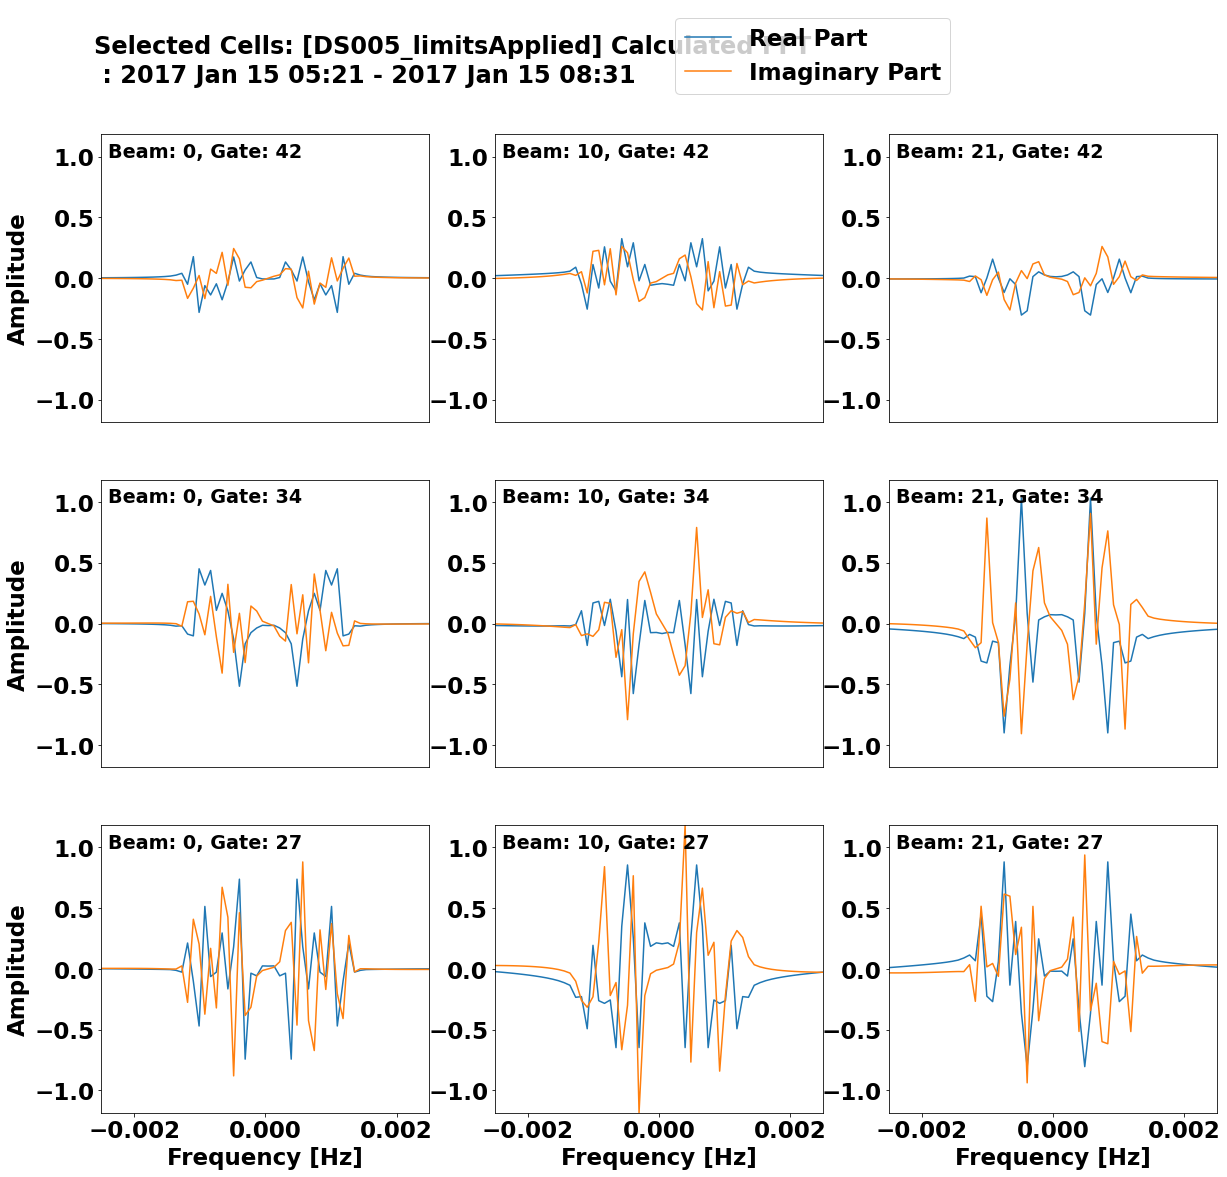

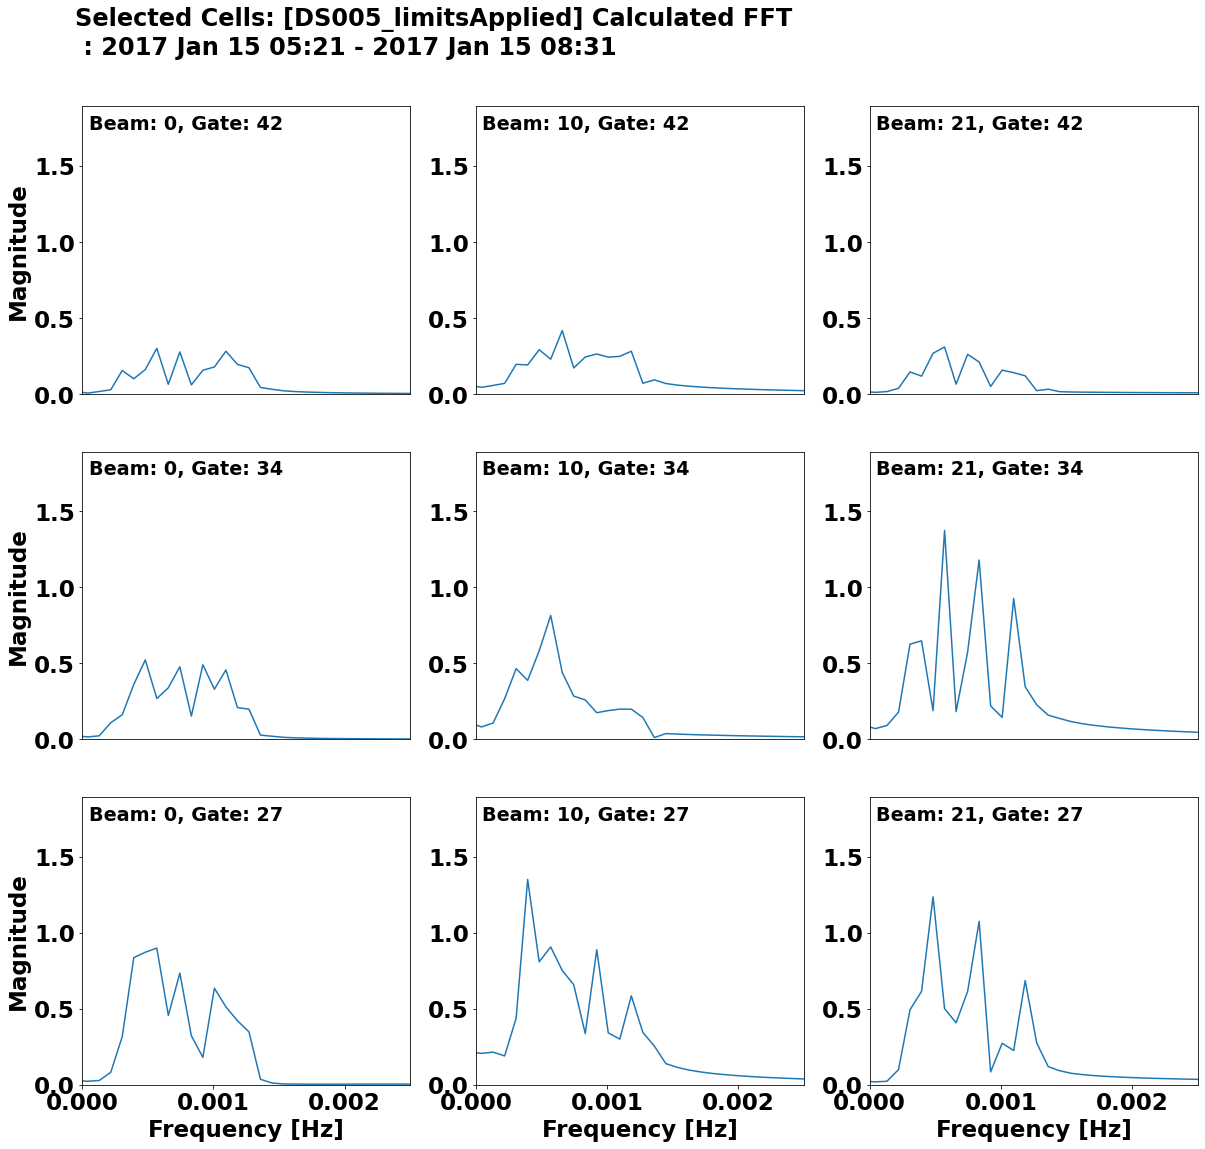

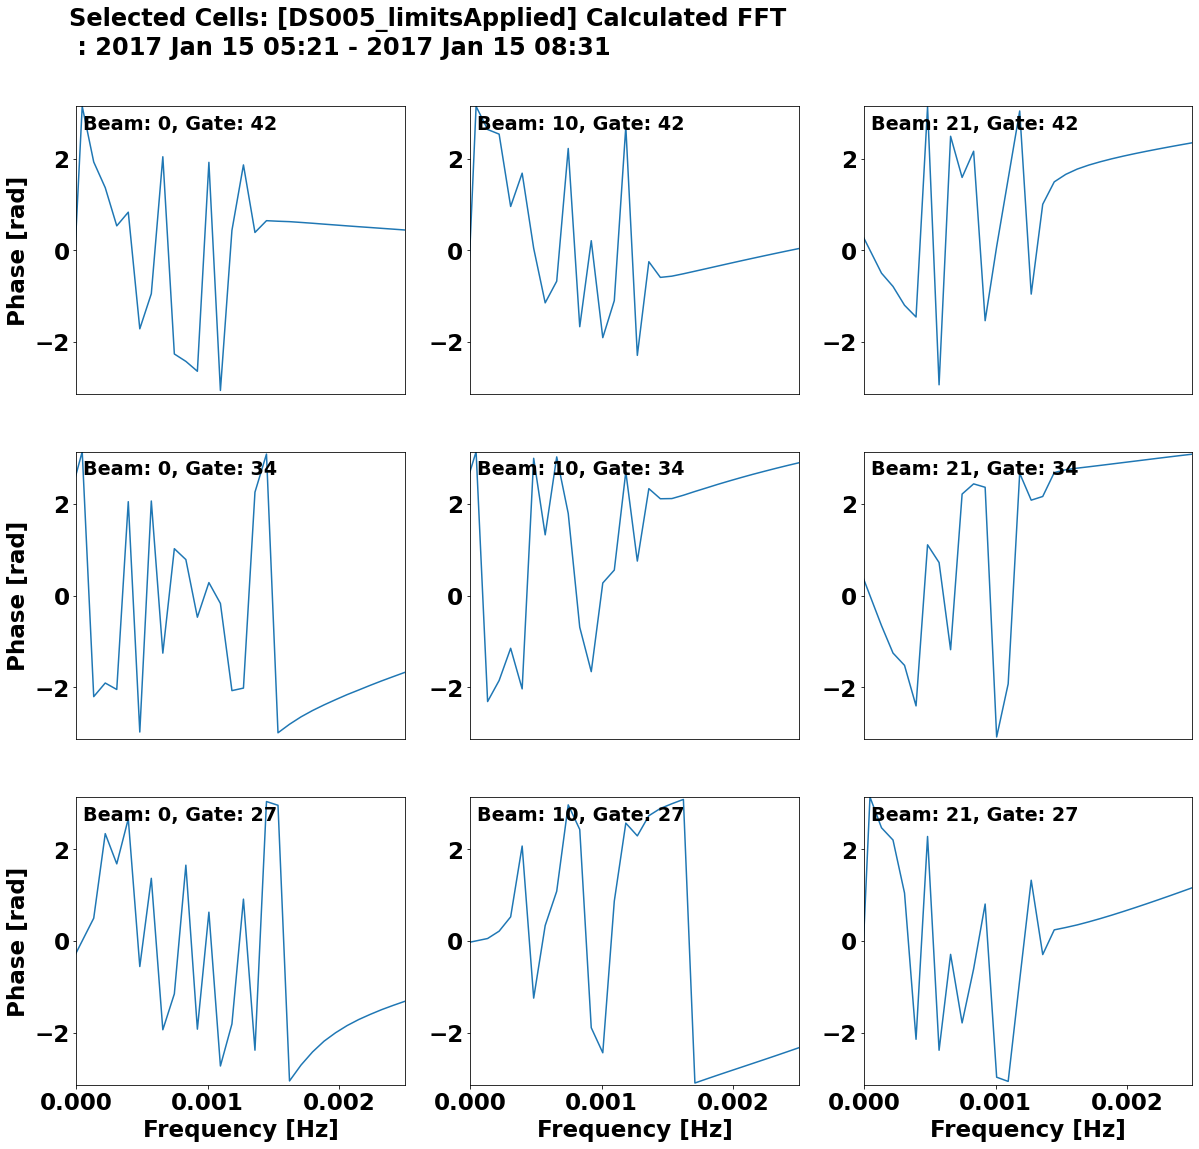

In [30]:
# We can look at the spectrum of select cells...
# from plotting.musicPlot import spectrumMultiPlot
spectrumMultiPlot(dataObj,xlim=(-0.0025,0.0025))
spectrumMultiPlot(dataObj,plotType='magnitude',xlim=(0,0.0025))
spectrumMultiPlot(dataObj,plotType='phase',xlim=(0,0.0025))

{'cbar_pcoll': <matplotlib.collections.PolyCollection at 0x7f439a4dc5b0>,
 'cbar_label': 'ABS(Spectral Density)'}

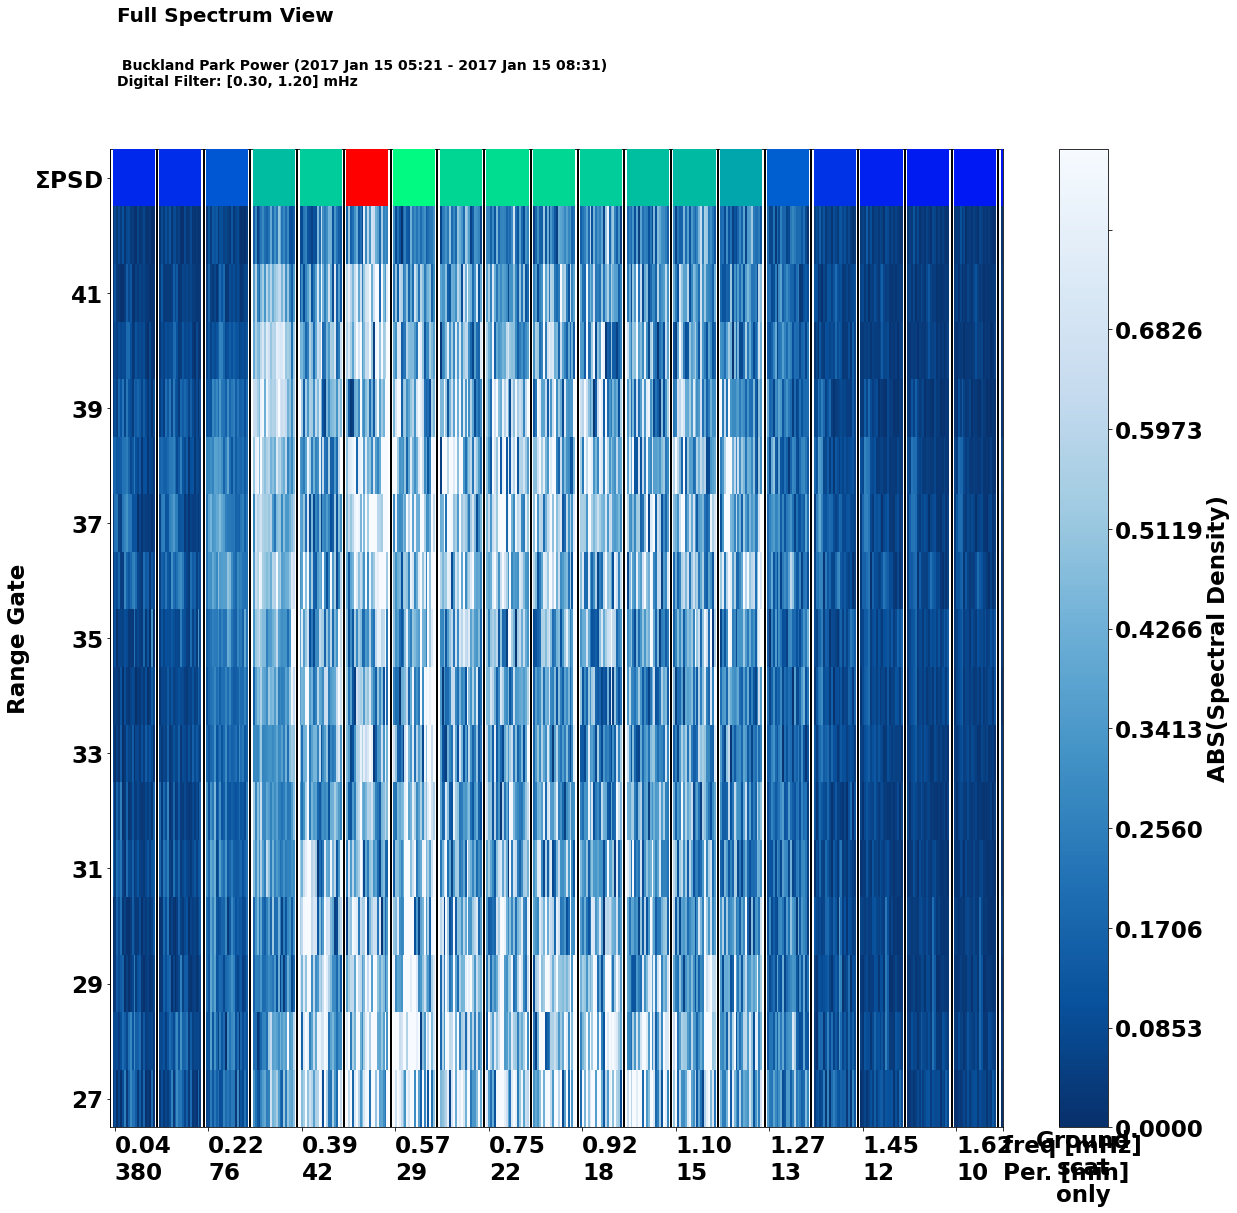

In [31]:
# We can also plot the full spectrum.  Here, every FFT bin contains 16 slices,
# showing the data for each of the 16 radar beams from left to right.
# Range gates are shown on the y-axis.
# from plotting.musicPlot import plotFullSpectrum
plotFullSpectrum(dataObj,xlim=(0,0.00175))

### MUSIC Processing

In [32]:
# Calculate the cross-spectral matrix Dlm.
# from music import calculateDlm
calculateDlm(dataObj)

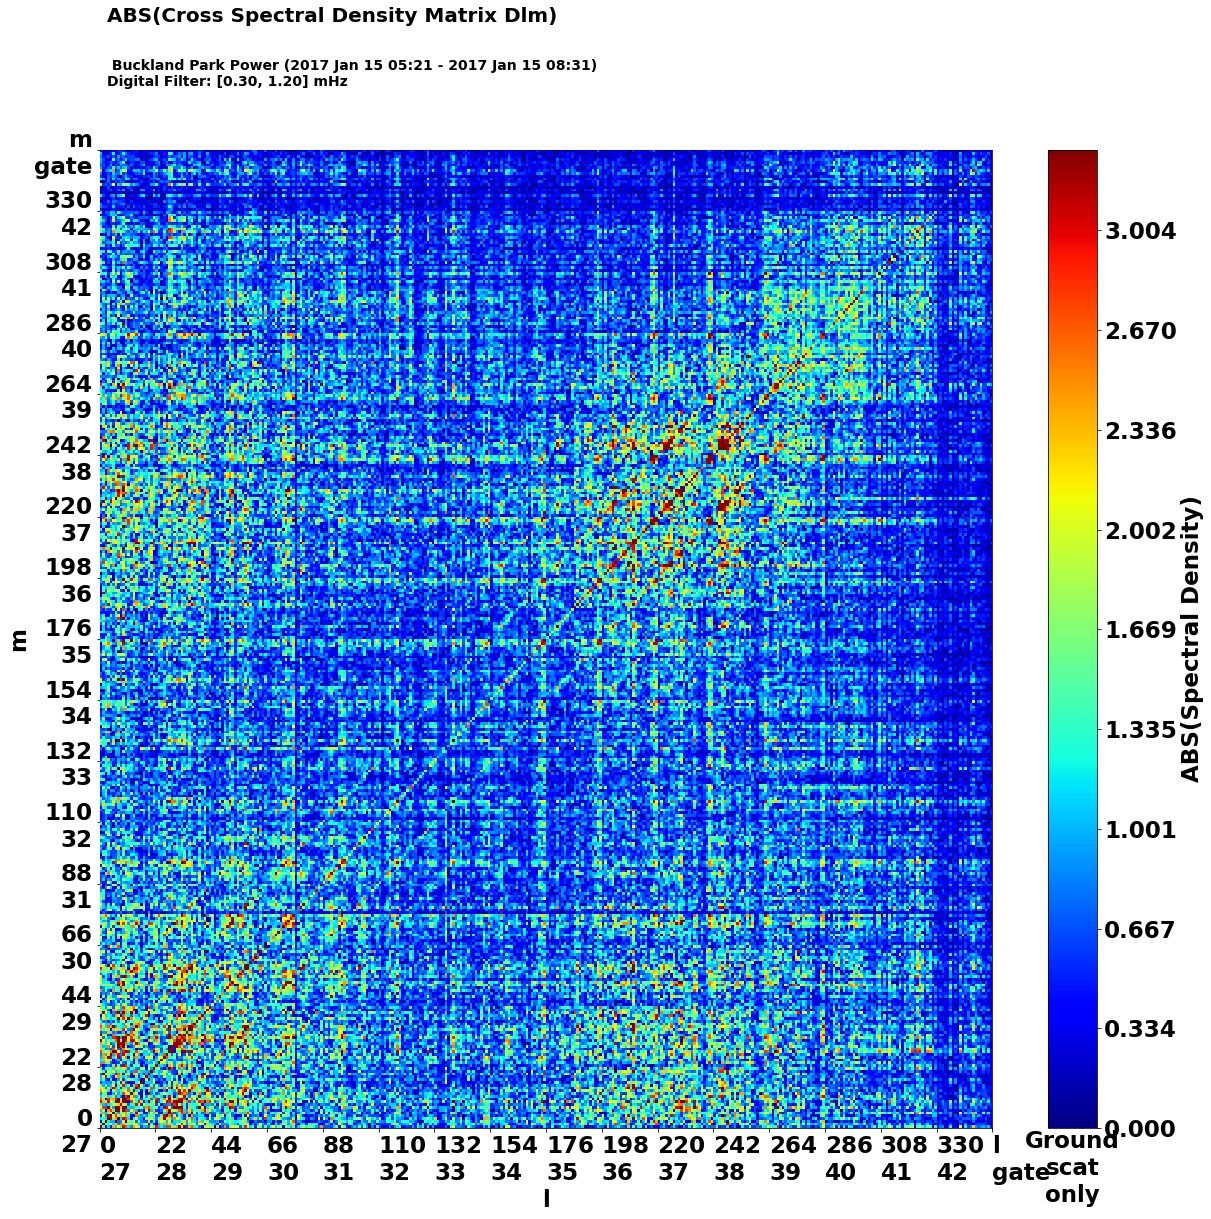

In [33]:
# We can look at the Dlm matrix.  This usually isn't necessary for routine processing, but
# it is good to know where the numbers are going...
# from plotting.musicPlot import plotDlm
plotDlm(dataObj)

In [34]:
# Now, we finally run detect the horizontal wave numbers.
# from music import calculateKarr
calculateKarr(dataObj)

/home/fran/code/newMusic/MUSIC/pyDARNmusic/plotting/musicPlot.py: 1411: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/fran/code/newMusic/MUSIC/pyDARNmusic/plotting/musicPlot.py: 1428: UserWarning: FixedFormatter should only be used together with FixedLocator


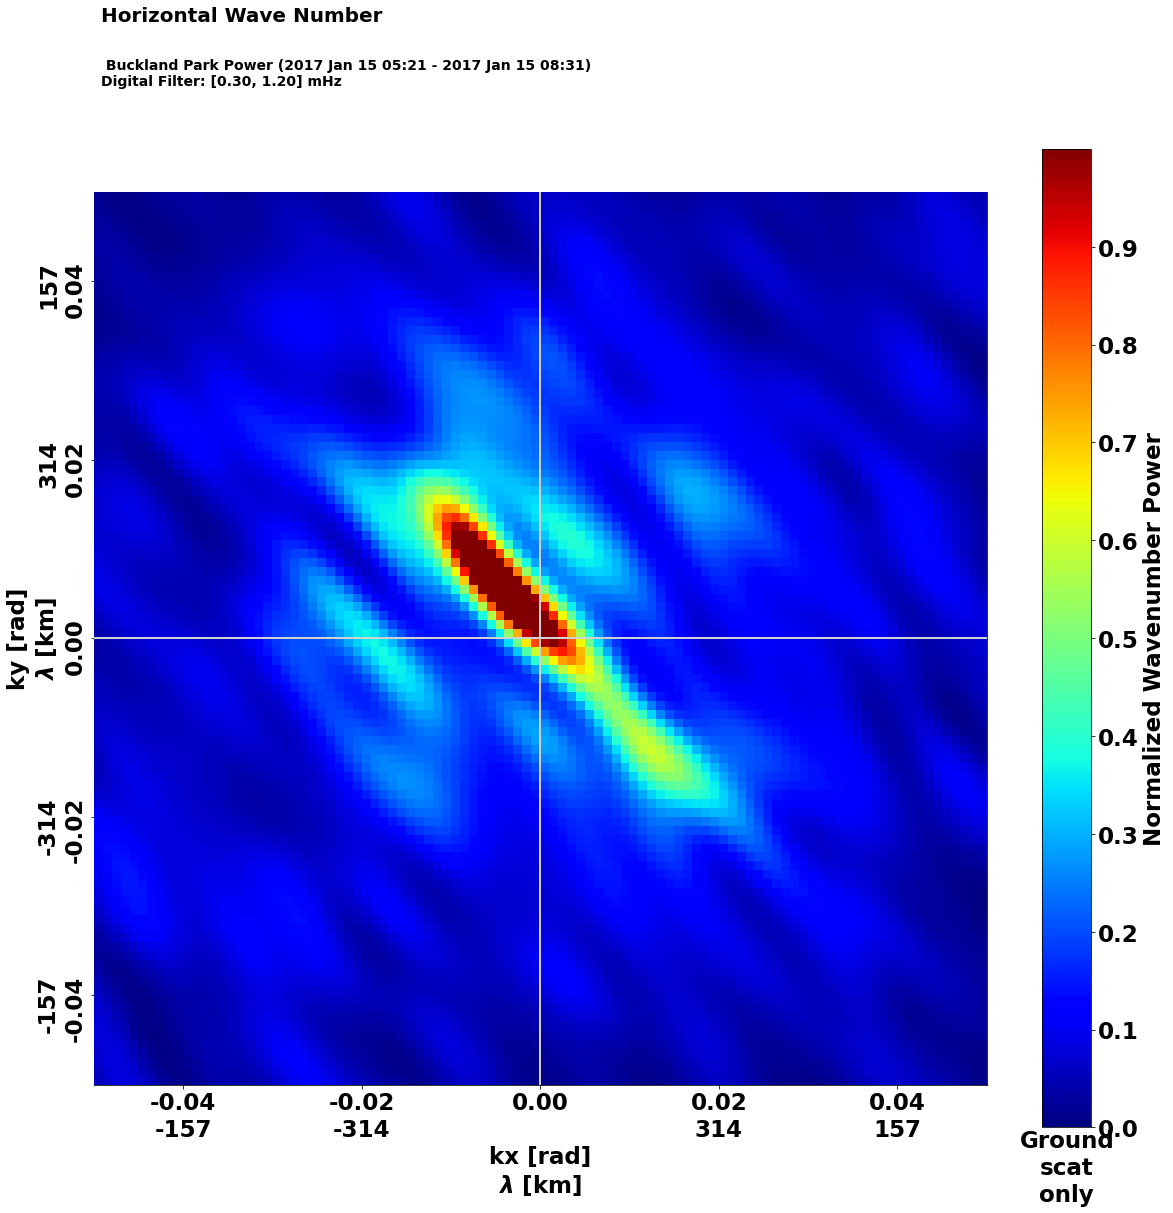

In [35]:
# We can then plot the final result.
# from plotting.musicPlot import plotKarr
plotKarr(dataObj)

In [36]:
# Again, we can see all of the history gone into processing this plot.
dataObj.active.printHistory()

2022-09-13 14:29:08.577986 [DS000_originalFit] Original Fit Data
2022-09-13 14:29:28.744609 [DS001_limitsApplied] Limits Applied: gate: 27,42; range [km]: 623,943; time: 2017-01-15/03:39,2017-01-15/10:11
2022-09-13 14:29:30.450271 [DS002_beamInterpolated] Beam Linear Interpolation
2022-09-13 14:29:33.204906 [DS003_timeInterpolated] Time Linear Interpolation
2022-09-13 14:29:35.131531 [DS004_filtered] Filter: blackman, Nyquist: 0.004166666666666667 Hz, Cuttoff: [0.0003, 0.0012] Hz, Numtaps: 101
2022-09-13 14:29:36.911315 [DS005_limitsApplied] Limits Applied: time: 2017-01-15/05:21,2017-01-15/08:31
2022-09-13 14:29:38.386435 [DS005_limitsApplied] Calculated FFT
2022-09-13 14:29:41.415636 [DS005_limitsApplied] Calculated Cross-Spectral Matrix Dlm
2022-09-13 14:30:08.752272 [DS005_limitsApplied] Calculated kArr


### Feature/Signal Detection

/home/fran/code/newMusic/MUSIC/pyDARNmusic/utils/musicUtils.py: 1195: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
/home/fran/code/newMusic/MUSIC/pyDARNmusic/plotting/musicPlot.py: 1411: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/fran/code/newMusic/MUSIC/pyDARNmusic/plotting/musicPlot.py: 1428: UserWarning: FixedFormatter should only be used together with FixedLocator


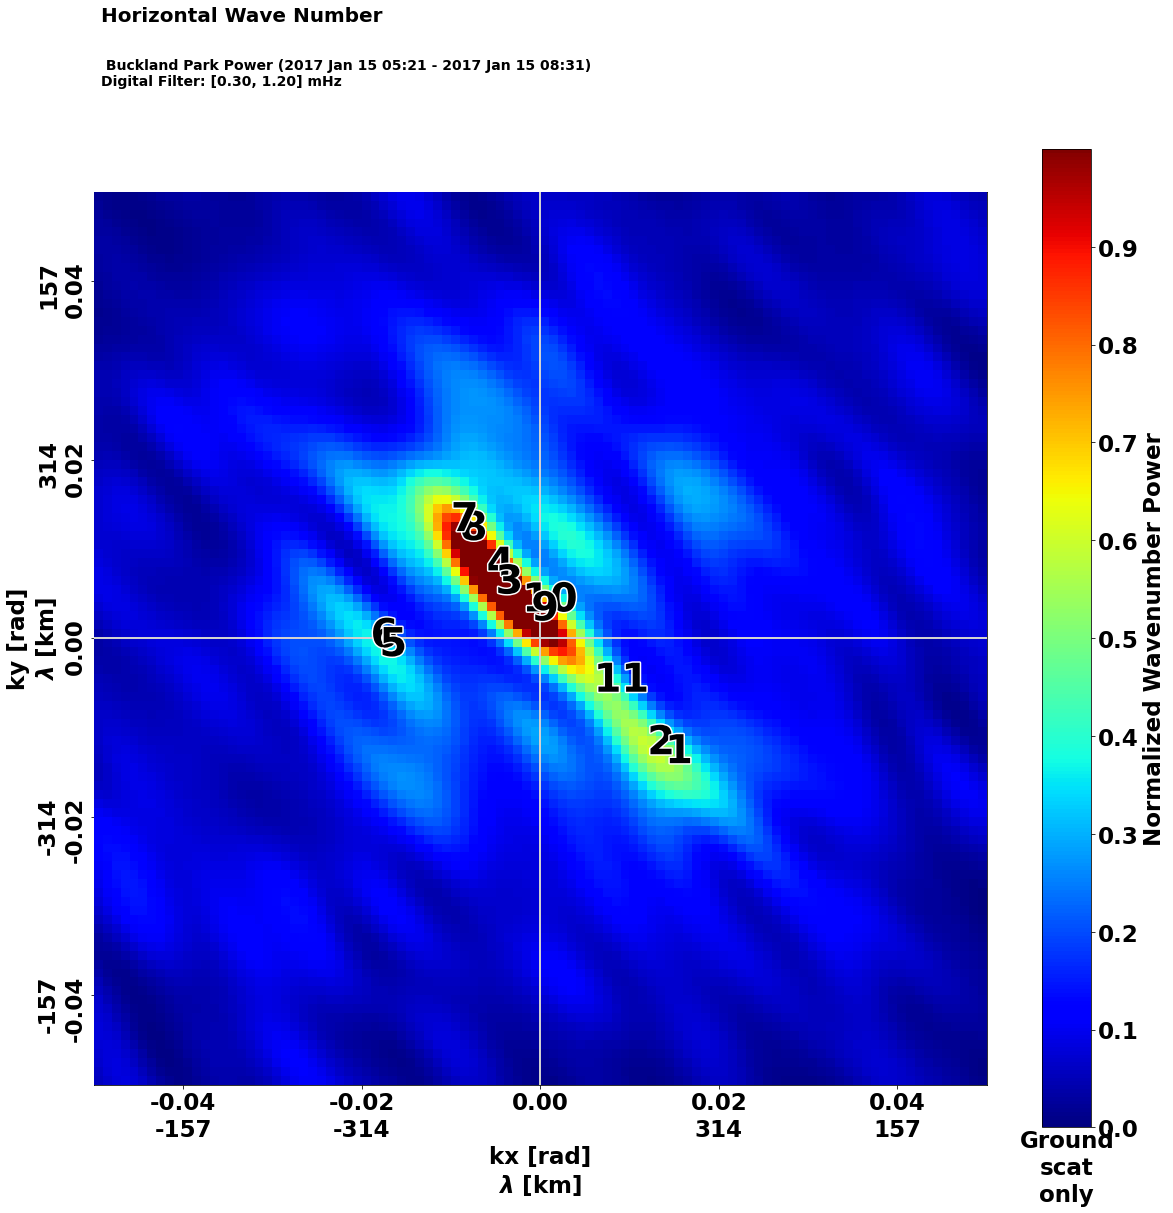

In [37]:
# We can use the image processing library in scikit-image to automatically find the peaks representing signals.
# from music import detectSignals
detectSignals(dataObj)
plotKarr(dataObj)

In [38]:
#All of the parameters connected with these signals is located in the sigDectect attribute.
dataObj.active.sigDetect.info

[{'labelInx': 1,
  'order': 6,
  'area': 6.0,
  'max': 0.37302873,
  'maxpos': (31, 49),
  'kx': -0.019000000000000003,
  'ky': -0.0010000000000000009,
  'k': 0.01902629759044045,
  'lambda_x': -330.69396353576764,
  'lambda_y': -6283.18530717958,
  'lambda': 330.2368880394524,
  'azm': -93.01278750418334,
  'freq': 0.00048245614035087684,
  'period': 2072.7272727272743,
  'vel': 159.32481440499885},
 {'labelInx': 2,
  'order': 5,
  'area': 9.0,
  'max': 0.37509832,
  'maxpos': (32, 48),
  'kx': -0.018,
  'ky': -0.0020000000000000018,
  'k': 0.01811077027627483,
  'lambda_x': -349.0658503988659,
  'lambda_y': -3141.59265358979,
  'lambda': 346.93087104144763,
  'azm': -96.34019174590992,
  'freq': 0.00048245614035087684,
  'period': 2072.7272727272743,
  'vel': 167.3789290112246},
 {'labelInx': 3,
  'order': 7,
  'area': 95.0,
  'max': 0.9787466,
  'maxpos': (40, 62),
  'kx': -0.009999999999999998,
  'ky': 0.012,
  'k': 0.015620499351813307,
  'lambda_x': -628.3185307179588,
  'lambda_

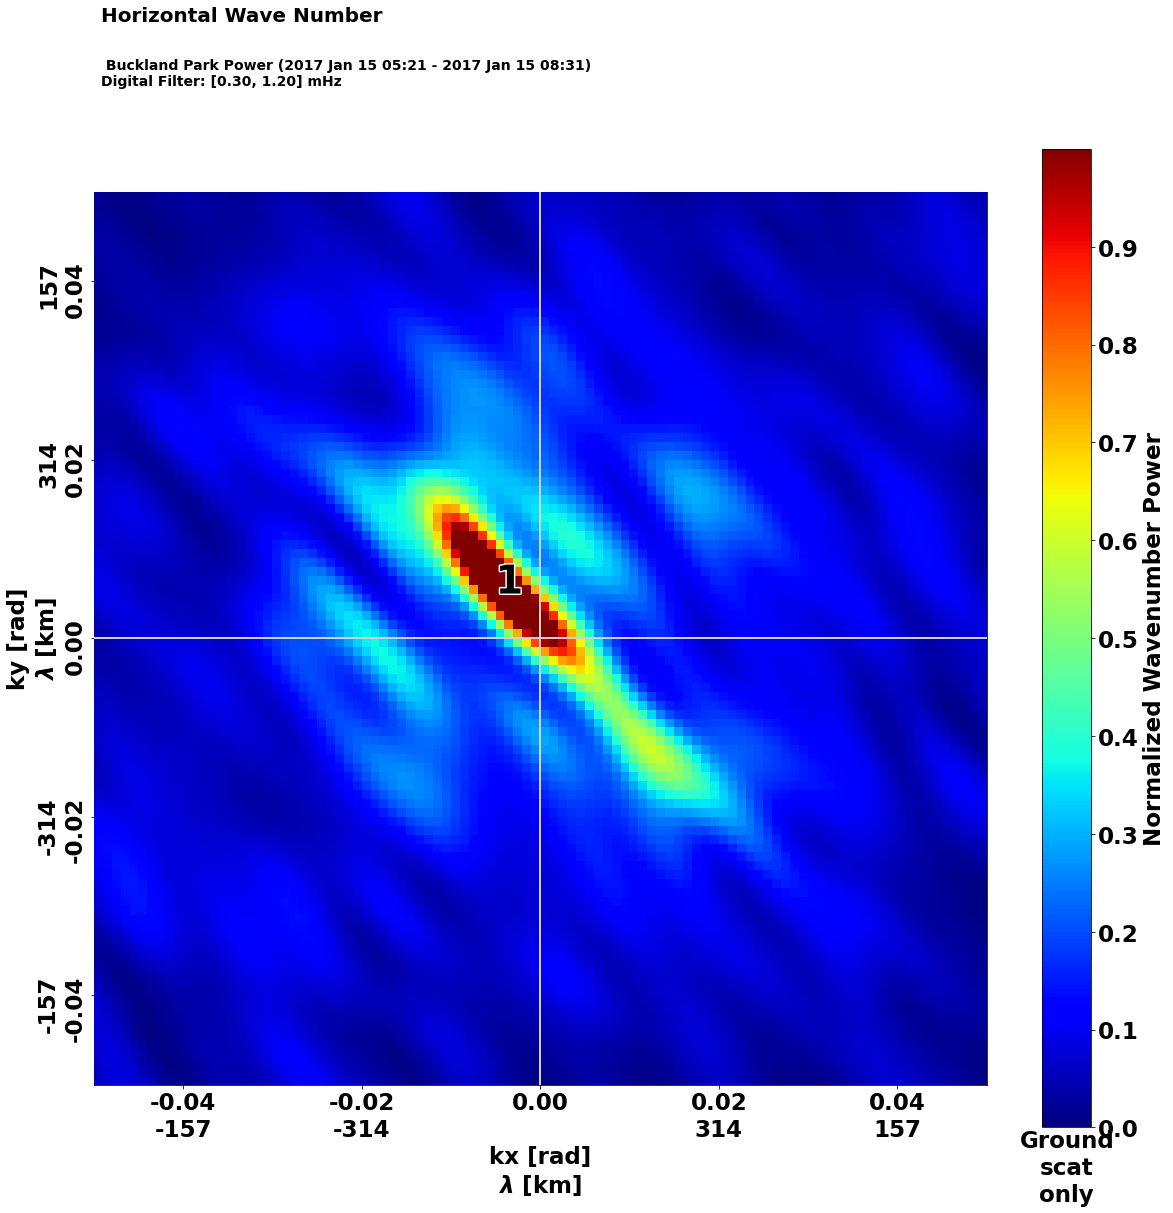

In [39]:
# It is possible to manually add a signal peak in.
# All appropriate associated wave parameters will be calculated.
# from music import add_signal
add_signal(0.013,-0.015,dataObj)
plotKarr(dataObj,maxSignals=1)

In [40]:
dataObj.active.sigDetect.info

[{'labelInx': 6,
  'order': 1,
  'area': 56.0,
  'max': 1.616931,
  'maxpos': (45, 55),
  'kx': -0.004999999999999999,
  'ky': 0.0050000000000000044,
  'k': 0.007071067811865478,
  'lambda_x': -1256.6370614359175,
  'lambda_y': 1256.6370614359162,
  'lambda': 888.5765876316729,
  'azm': -44.99999999999997,
  'freq': 0.00048245614035087684,
  'period': 2072.7272727272743,
  'vel': 428.6992308749296},
 {'labelInx': 5,
  'order': 2,
  'area': 26.0,
  'max': 1.5657388,
  'maxpos': (44, 57),
  'kx': -0.006,
  'ky': 0.006999999999999996,
  'k': 0.009219544457292886,
  'lambda_x': -1047.1975511965977,
  'lambda_y': 897.5979010256557,
  'lambda': 681.5071326229609,
  'azm': -40.60129464500449,
  'freq': 0.00048245614035087684,
  'period': 2072.7272727272743,
  'vel': 328.79730082686683},
 {'labelInx': 7,
  'order': 3,
  'area': 11.0,
  'max': 1.4507776,
  'maxpos': (48, 53),
  'kx': -0.0020000000000000018,
  'ky': 0.0030000000000000027,
  'k': 0.0036055512754639926,
  'lambda_x': -3141.5926535

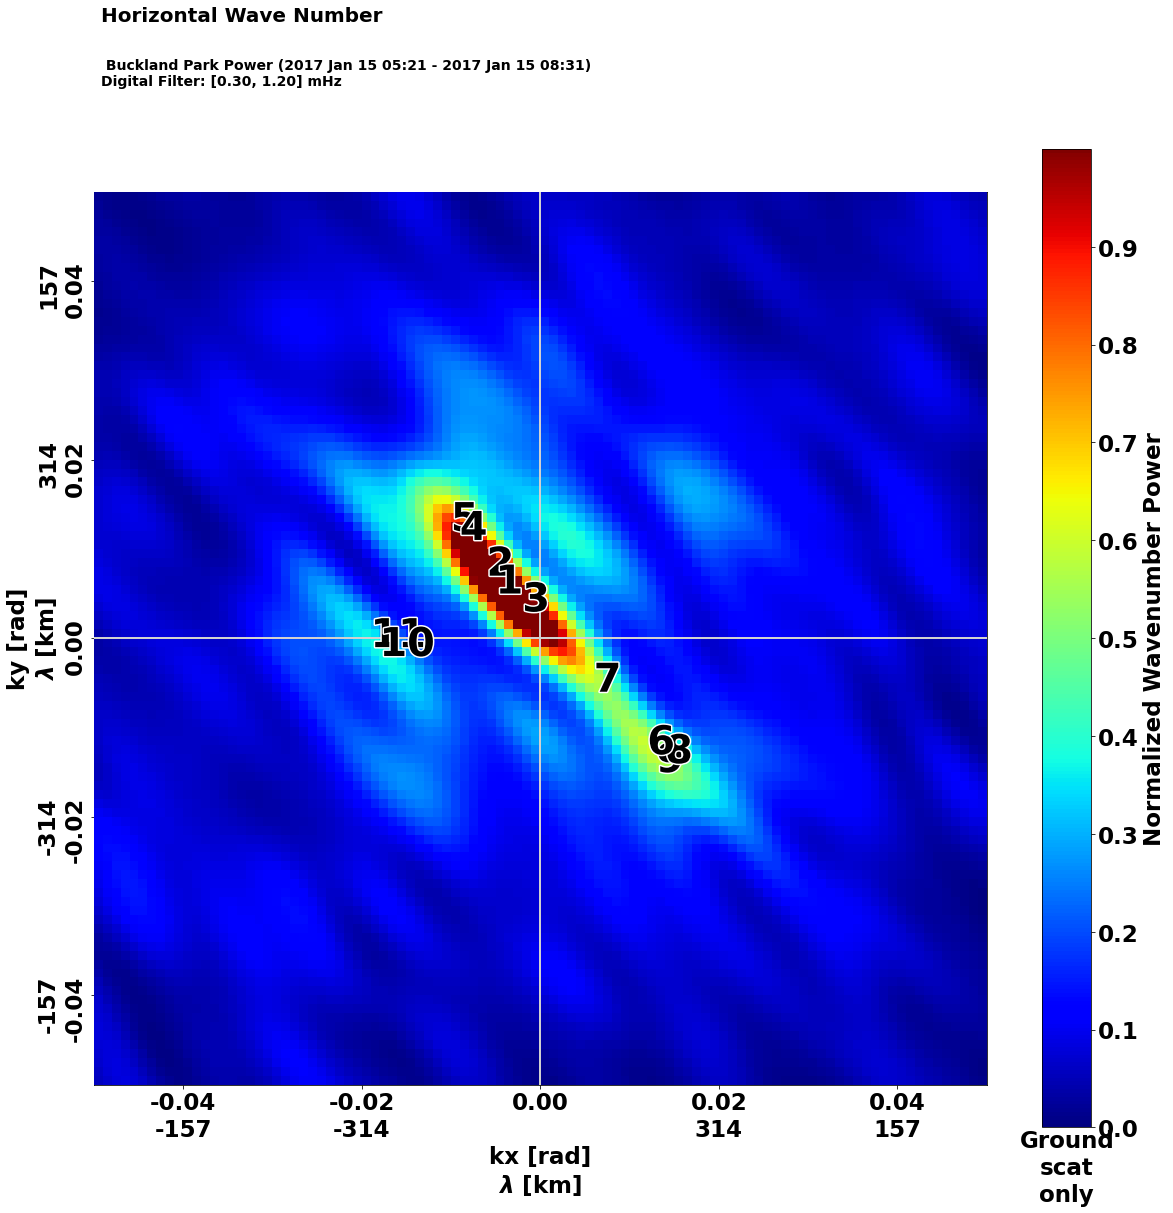

In [41]:
#Signals can also be removed from the database.
# from music import del_signal
del_signal(4,dataObj)
plotKarr(dataObj)
# fig.savefig("/home/fran/Pictures/CEDAR2022/bpkKRA.png")

/home/fran/code/newMusic/MUSIC/pyDARNmusic/plotting/musicPlot.py: 1245: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/fran/code/newMusic/MUSIC/pyDARNmusic/plotting/musicPlot.py: 1261: UserWarning: FixedFormatter should only be used together with FixedLocator


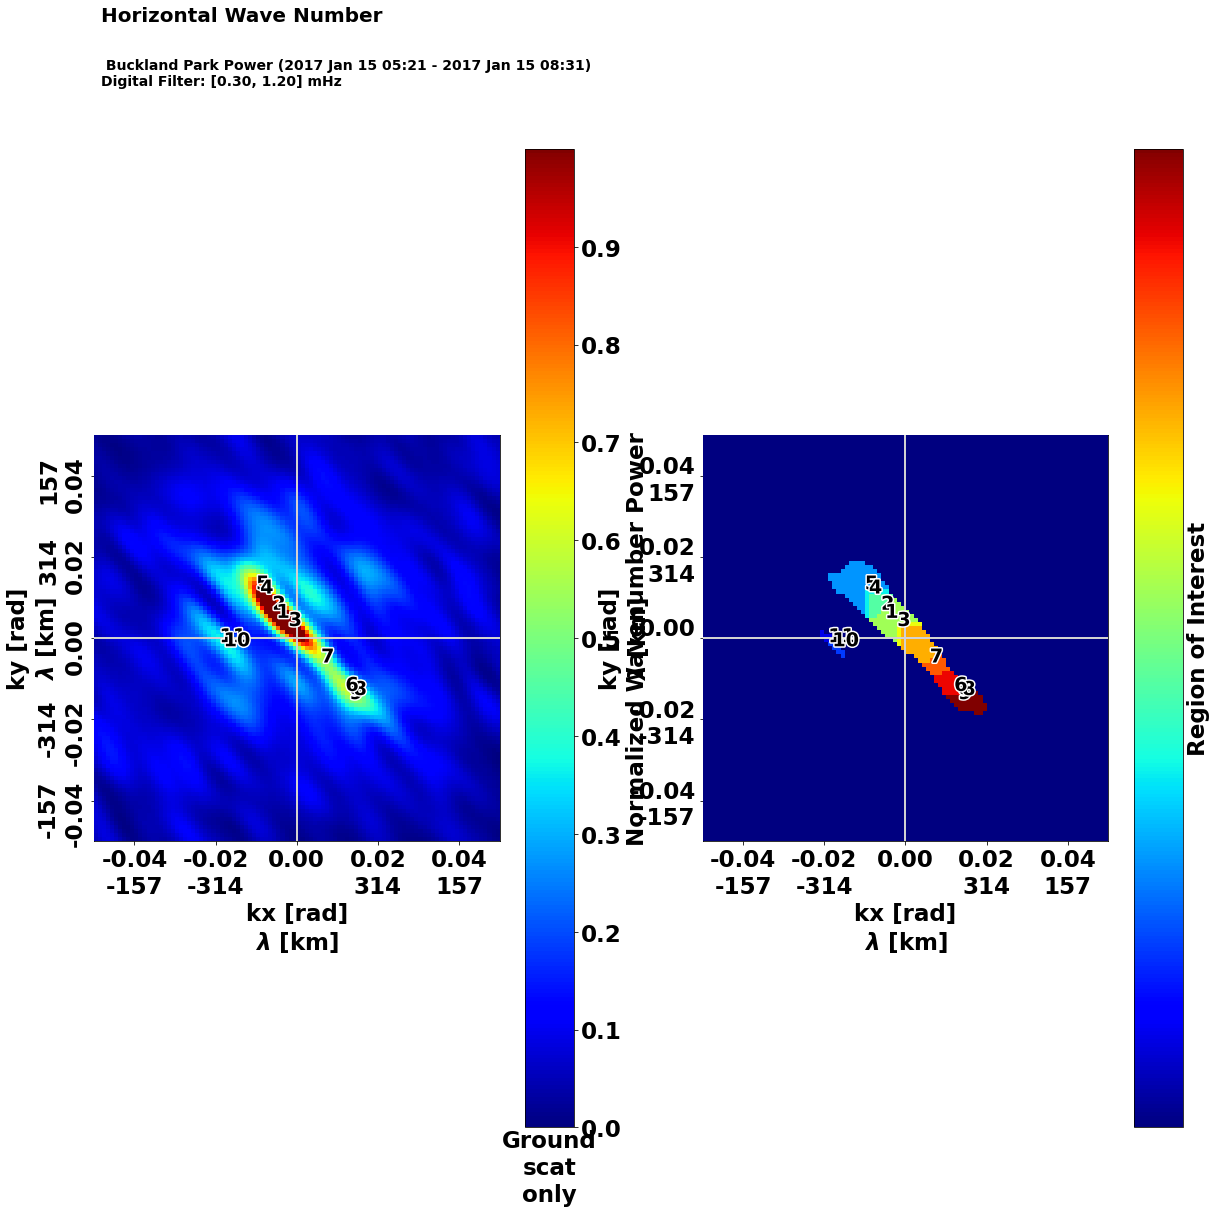

In [42]:
# To get some insight on how the signal processing algorithm works, we can plot the detected groups.
# You can adjust the threshold and neighborhood keywords on pydarn.proc.music.detectSignals() to tweak
# the autodetection.
# from plotting.musicPlot import plotKarrDetected
plotKarrDetected(dataObj)